In [43]:
#Importing necessary packages
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from scipy.stats import shapiro, kstest, levene, ttest_1samp, ttest_ind
from scipy.stats import gaussian_kde
from matplotlib import gridspec
from scipy import stats
from statsmodels.formula.api import ols
from matplotlib.lines import Line2D

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

In [4]:
#Important data
df = pd.read_csv ('Landforms.csv')
LWData = pd.read_csv ('DeltaLW.csv')
LWDataFan = pd.read_csv ('FluvialFanLW.csv')
AData = pd.read_csv ('DeltaAngles.csv')
ADataFan = pd.read_csv ('FluvialFanAngles.csv')

# Figures

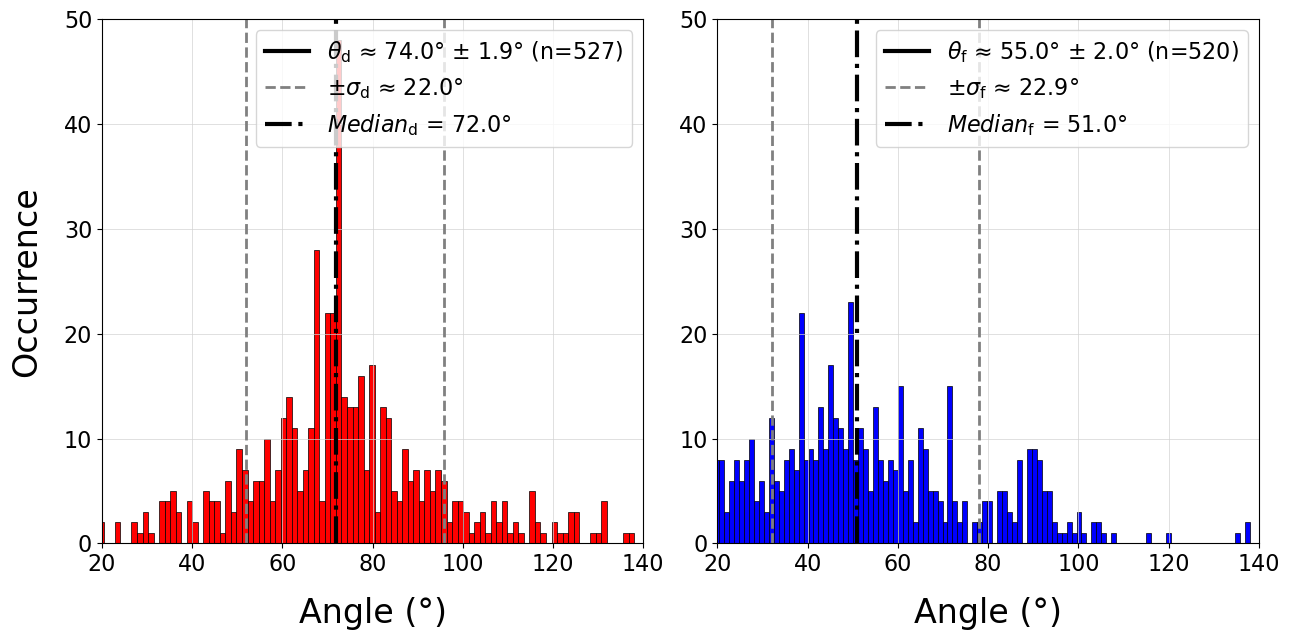

In [5]:
# Figures 5a & 5b 

def plot_histogram_and_statistics(data, subplot_loc, xlim=(20, 140), ylim=(0, 50)):
    ax = plt.subplot(1, 2, subplot_loc)
    ax.set_facecolor('white')
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

    # Plot histogram
    ax.hist(data, bins=120, color='Red' if subplot_loc == 1 else 'Blue', edgecolor='black', linewidth=0.5)

    # Labels
    ax.set_xlabel('Angle (°)', fontsize=24, labelpad=15)
    if subplot_loc == 1:
        ax.set_ylabel('Occurrence', fontsize=24, labelpad=15)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Statistics
    mean_value = data.mean()
    std_value = data.std()
    median_value = data.median()
    n_value = len(data)
    ci_margin = 1.96 * (std_value / np.sqrt(n_value))

    # Choose correct subscript
    suffix = 'd' if subplot_loc == 1 else 'f'

    # Labels
    mean_label = fr'$\theta_{{\mathrm{{{suffix}}}}}$ ≈ {mean_value:.1f}° ± {ci_margin:.1f}° (n={n_value})'
    std_label = fr'$\pm \sigma_{{\mathrm{{{suffix}}}}}$ ≈ {std_value:.1f}°'
    median_label = fr'$Median_{{\mathrm{{{suffix}}}}}$ = {median_value:.1f}°'

    # Store handles in desired order
    mean_handle, = ax.plot([], [], color='black', linestyle='-', linewidth=3, label=mean_label)  # dummy
    std_handle = ax.axvline(mean_value + std_value, color='gray', linestyle='--', linewidth=2, label=std_label)
    ax.axvline(mean_value - std_value, color='gray', linestyle='--', linewidth=2)
    median_handle = ax.axvline(median_value, color='black', linestyle='-.', linewidth=3, label=median_label)

    # Apply legend in desired order
    ax.legend(handles=[mean_handle, std_handle, median_handle], fontsize=16)
    ax.tick_params(axis='both', labelsize=16)

# Create the figure and plot both histograms
plt.figure(figsize=(13, 6.5))
plot_histogram_and_statistics(AData.Angle, 1)
plot_histogram_and_statistics(ADataFan.Angle, 2)
plt.tight_layout()
plt.show()


C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\362143726.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delta_means = delta_data.groupby('Name')['Angle'].mean()
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\362143726.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\362143726.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fan_means = fan_data.groupby('Name')['Angle'].mean()
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\362143726.py

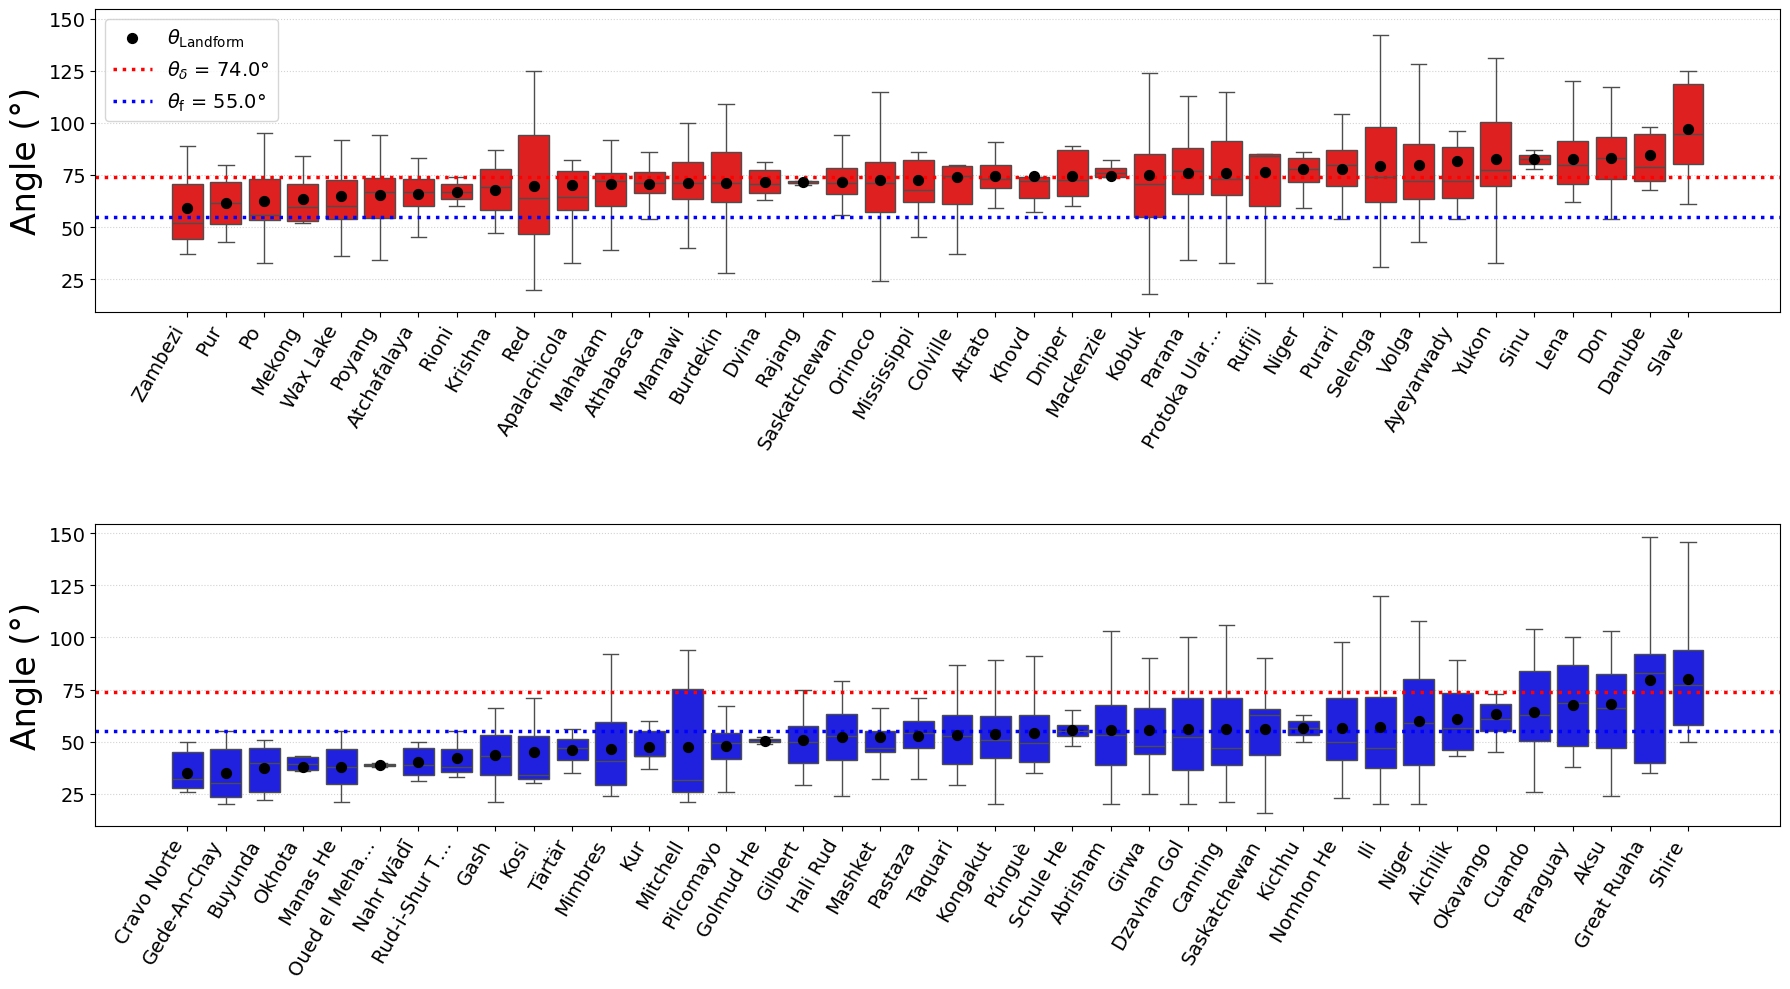

In [6]:
#Figures 5c and 5d

# Add 'Group' column
ADataFan['Group'] = 'Fluvial Fan'
AData['Group'] = 'Delta'
combined = pd.concat([AData[['Name', 'Angle', 'Group']], ADataFan[['Name', 'Angle', 'Group']]])

# Count samples per Name
name_counts = combined['Name'].value_counts()

# Calculate group means
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()

# Sort names by mean angle (ascending)
delta_mean_order = (
    combined[combined['Group'] == 'Delta']
    .groupby('Name')['Angle']
    .mean()
    .sort_values(ascending=True)
    .index.tolist()
)

fan_mean_order = (
    combined[combined['Group'] == 'Fluvial Fan']
    .groupby('Name')['Angle']
    .mean()
    .sort_values(ascending=True)
    .index.tolist()
)

# Truncate long names if needed
delta_mean_order = [name[:12] + '…' if len(name) > 12 else name for name in delta_mean_order]
fan_mean_order = [name[:12] + '…' if len(name) > 12 else name for name in fan_mean_order]
combined['Name'] = combined['Name'].apply(lambda name: name[:12] + '…' if len(name) > 12 else name)

# Create figure with increased width for better label spacing
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharey=True)

# Prepare delta data
delta_data = combined[combined['Group'] == 'Delta'].copy()
delta_data['Name'] = pd.Categorical(delta_data['Name'], categories=delta_mean_order, ordered=True)
combined['Name'] = combined['Name'].apply(lambda name: name[:12] + '…' if len(name) > 12 else name)

# Delta boxplot
sns.boxplot(data=delta_data, x='Name', y='Angle', color='red', showfliers=False, ax=ax1)

# Plot per-landform theta
delta_means = delta_data.groupby('Name')['Angle'].mean()
ax1.scatter(
    range(len(delta_mean_order)),
    delta_means[delta_mean_order],
    color='black',
    zorder=5,
    label=rf'$\theta_{{\mathrm{{Landform}}}}$',
    s=50
)
ax1.axhline(avg_delta_angle, color='red', linestyle=':', linewidth=2.5, 
            label=rf'$\theta_{{\delta}}$ = {avg_delta_angle:.1f}°')
ax1.axhline(avg_fan_angle, color='blue', linestyle=':', linewidth=2.5, 
            label=rf'$\theta_{{\mathrm{{f}}}}$ = {avg_fan_angle:.1f}°')
ax1.set_title('', fontsize=32)
ax1.set_ylabel('Angle (°)', fontsize=24)
ax1.set_xticklabels(
    delta_mean_order,
    rotation=60, ha='right', fontsize=14
)

ax1.legend(fontsize=14, loc='upper left')
ax1.grid(axis='y', linestyle=':', color='lightgrey')
ax1.set_xlabel('')
ax1.tick_params(axis='y', labelsize=14) 

# Prepare fan data
fan_data = combined[combined['Group'] == 'Fluvial Fan'].copy()
fan_data['Name'] = pd.Categorical(fan_data['Name'], categories=fan_mean_order, ordered=True)

# Fluvial Fan boxplot
sns.boxplot(data=fan_data, x='Name', y='Angle', color='blue', showfliers=False, ax=ax2)
# Plot per-landform mean
fan_means = fan_data.groupby('Name')['Angle'].mean()
ax2.scatter(range(len(fan_mean_order)), fan_means[fan_mean_order], color='black', zorder=5, s=50)

ax2.axhline(avg_delta_angle, color='red', linestyle=':', linewidth=2.5)
ax2.axhline(avg_fan_angle, color='blue', linestyle=':', linewidth=2.5)
ax2.set_title('', fontsize=32)
ax2.set_ylabel('Angle (°)', fontsize=24)
ax2.set_xticklabels(
    fan_mean_order,
    rotation=60, ha='right', fontsize=14
)
ax2.grid(axis='y', linestyle=':', color='lightgrey')
ax2.set_xlabel('')
ax2.tick_params(axis='y', labelsize=14) 

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
plt.show()


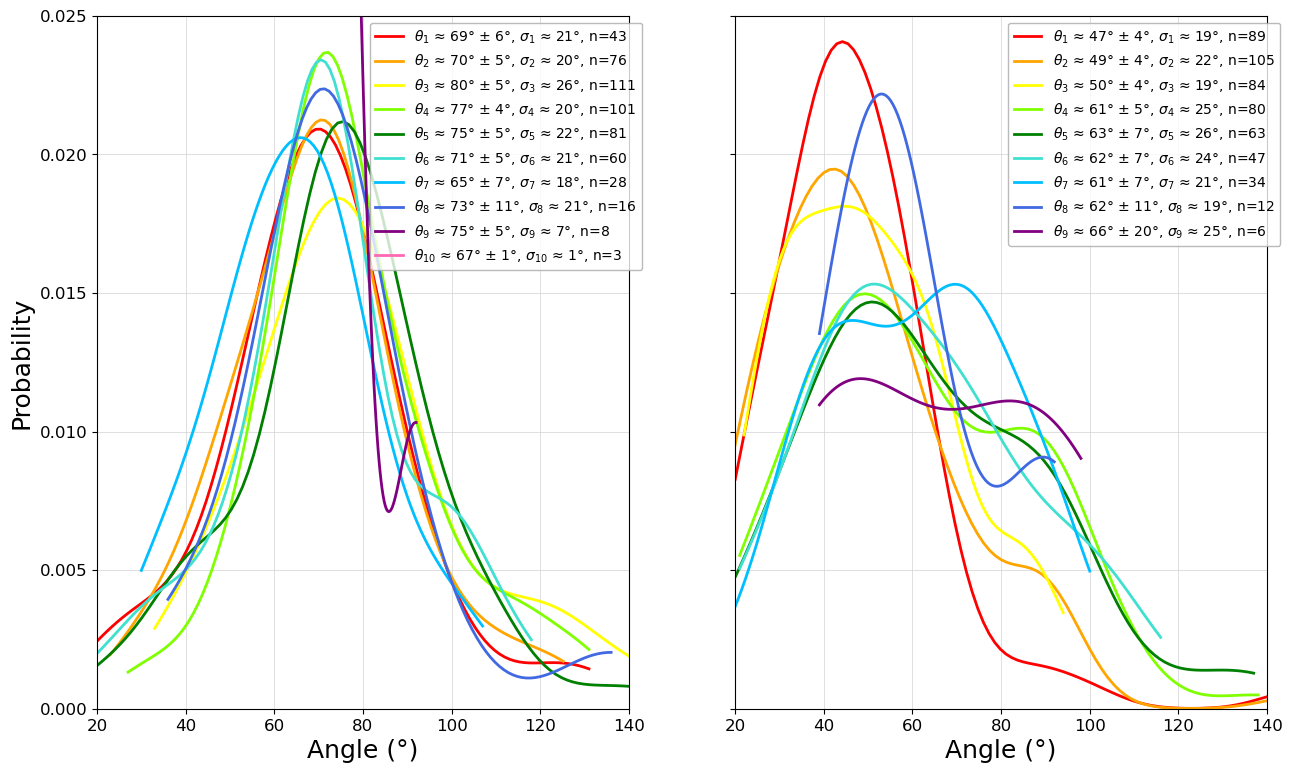

In [7]:
#Figures 6a and 6b

def plot_histogram(ax, grouped_data, title, x_label, x_limit, y_limit):
    colors = {'1': 'red', '2': 'orange', '3': 'yellow', '4': 'chartreuse', '5': 'green', '6': 'turquoise',
              '7': 'deepskyblue', '8': 'royalblue', '9': 'purple', '10': 'hotpink'}

    for group_name, group_data in grouped_data:
        if len(group_data) < 2:
            continue

        # Plot the density curve only
        density = gaussian_kde(group_data)
        x_vals = np.linspace(group_data.min(), group_data.max(), 100)

        # Calculate statistics
        mean_val = group_data.mean()
        std_val = group_data.std()
        n_val = len(group_data)
        ci_margin = 1.96 * (std_val / np.sqrt(n_val))

        # Plot line and label with confidence interval
        ax.plot(
            x_vals,
            density(x_vals),
            color=colors[str(group_name)],
            label=(
                f"$\\theta_{{{title}{group_name}}}$ ≈ {mean_val:.0f}° ± {ci_margin:.0f}°, "
                f"$\\sigma_{{{title}{group_name}}}$ ≈ {std_val:.0f}°, "
                f"n={n_val}"
            ),
            linewidth=2
        )

    # Titles and labels
    ax.set_title(title, loc="left", fontsize=24)
    ax.set_ylabel('Probability', fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    ax.set_xlim(x_limit)
    if y_limit:
        ax.set_ylim(y_limit)
    ax.tick_params(axis='both', labelsize=12)

    # Set background and grid
    ax.set_facecolor('white')
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)

    # Add legend with smaller font
    legend = ax.legend(fontsize=10, bbox_to_anchor=(0.5, 1), loc='upper left')

    # Style legend box
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('darkgrey')


# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 9), sharey=True, sharex=True)

# Plot histogram for delta data
plot_histogram(axs[0], AData.groupby('Order')['Angle'], '', 'Angle (°)', (20, 140), (0, 0.025))

# Plot histogram for fluvial fan data
plot_histogram(axs[1], ADataFan.groupby('Order')['Angle'], '', 'Angle (°)', (20, 140), (0, 0.025))

# Remove y-axis label from the right plot
axs[1].set_ylabel('')

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.95, hspace=0.5)

# Show the plot
plt.show()


C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\2296704983.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=AData, x='Type', y='Angle', palette=type_colors, cut=0, inner='box', ax=ax1)
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\2296704983.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(AData['Type'].unique(), rotation=10, ha='right', fontsize=12)


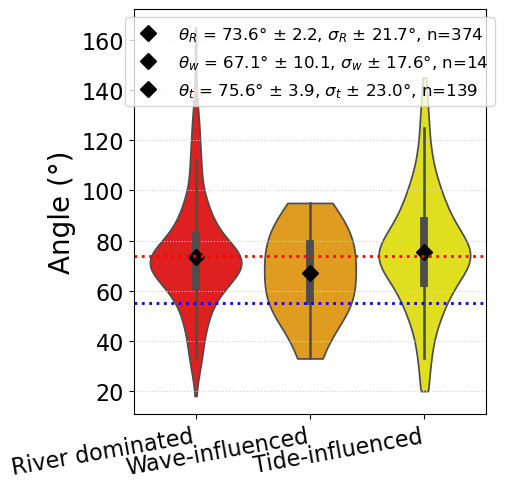

In [9]:
# Figure 7a

# Compute the type counts
type_counts = AData['Type'].value_counts()

type_colors = {
    'River dominated': 'red',
    'Tide-influenced': 'yellow',
    'Wave-influenced': 'orange'
}
# Delta Types Plot
fig1, ax1 = plt.subplots(figsize=(5, 5))
sns.violinplot(data=AData, x='Type', y='Angle', palette=type_colors, cut=0, inner='box', ax=ax1)

# Track legend handles and labels
handles = []
labels = []

# Add mean diamond markers and legend entries
for i, group in enumerate(AData['Type'].unique()):
    group_data = AData[AData['Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Abbreviations
    abbr = {'River dominated': 'R', 'Wave-influenced': 'w', 'Tide-influenced': 't'}.get(group, group)
    
    # Plot the diamond
    handle = ax1.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripted theta and sigma
    label = rf'$\theta_{{{abbr}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{abbr}}}$ ± {std_val:.1f}°, n={n}'
    
    handles.append(handle)
    labels.append(label)


# Add horizontal lines for delta and fan averages
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
ax1.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
ax1.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)

# Update x-tick labels (no counts)
ax1.set_xticklabels(AData['Type'].unique(), rotation=10, ha='right', fontsize=12)

# Improve labels and formatting
ax1.set_ylabel('Angle (°)', fontsize=20)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_title('', fontsize=24)
ax1.legend(handles, labels, fontsize=12, loc='upper center')
ax1.grid(axis='y', linestyle=':', color='lightgrey')
ax1.set_xlabel('')

plt.tight_layout()
plt.show()


C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\795362700.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=arctic_data, x='Hydroclimate_Type', y='Angle',
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\795362700.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Arctic', 'non-Arctic'], fontsize=16)


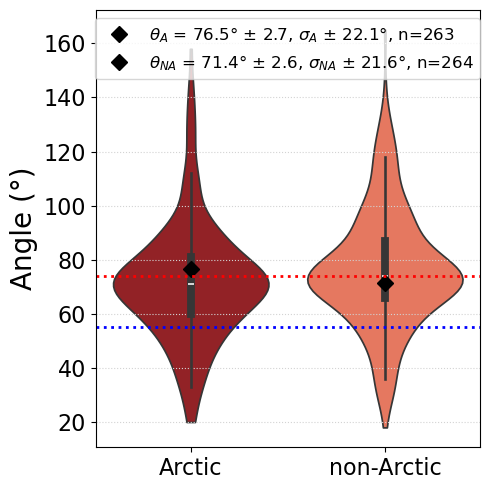

In [10]:
# Figure 7b

# Update 'Hydroclimate_Type' classification to abbreviations
AData['Hydroclimate_Type'] = AData['Hydroclimate'].apply(
    lambda x: 'A' if x == 6 else 'NA'
)

# Filter only Arctic and Non-Arctic rows
arctic_data = AData[AData['Hydroclimate_Type'].isin(['A', 'NA'])]

# Create violin plot
fig1, ax1 = plt.subplots(figsize=(5, 5))
sns.violinplot(data=arctic_data, x='Hydroclimate_Type', y='Angle',
               palette={'A': '#fb6a4a', 'NA': '#a50f15'},
               cut=0, inner='box', ax=ax1)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(['A', 'NA']):
    group_data = arctic_data[arctic_data['Hydroclimate_Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Plot diamond and collect handle
    handle = ax1.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripts and sample size
    label = rf'$\theta_{{{group}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{group}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Horizontal lines for delta and fan averages
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
ax1.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
ax1.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)

# Format plot to match the first plot
ax1.set_ylabel('Angle (°)', fontsize=20)
ax1.set_xlabel('', fontsize=12)
ax1.set_title('', fontsize=24)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xticklabels(['Arctic', 'non-Arctic'], fontsize=16)
ax1.grid(axis='y', linestyle=':', color='lightgrey')
ax1.legend(handles, labels, fontsize=12, loc='upper center')

plt.tight_layout()
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\2850539302.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=arctic_data, x='Hydroclimate_Type', y='Angle',
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\2850539302.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Arctic', 'non-Arctic'], fontsize=12)


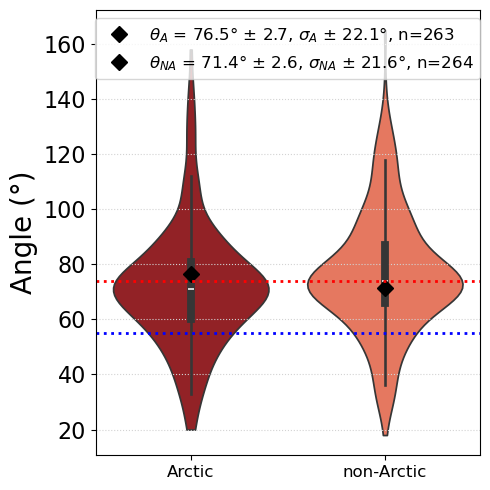

In [11]:
# Figure 7c

# Update 'Hydroclimate_Type' classification to abbreviations
AData['Hydroclimate_Type'] = AData['Hydroclimate'].apply(
    lambda x: 'A' if x == 6 else 'NA'
)

# Filter only Arctic and Non-Arctic rows
arctic_data = AData[AData['Hydroclimate_Type'].isin(['A', 'NA'])]

# Create violin plot
fig1, ax1 = plt.subplots(figsize=(5, 5))
sns.violinplot(data=arctic_data, x='Hydroclimate_Type', y='Angle',
               palette={'A': '#fb6a4a', 'NA': '#a50f15'},
               cut=0, inner='box', ax=ax1)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(['A', 'NA']):
    group_data = arctic_data[arctic_data['Hydroclimate_Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Plot diamond and collect handle
    handle = ax1.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripts and sample size
    label = rf'$\theta_{{{group}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{group}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Horizontal lines for delta and fan averages
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
ax1.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
ax1.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)

# Format plot to match the first plot
ax1.set_ylabel('Angle (°)', fontsize=20)
ax1.set_xlabel('', fontsize=12)
ax1.set_title('', fontsize=24)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xticklabels(['Arctic', 'non-Arctic'], fontsize=12)
ax1.grid(axis='y', linestyle=':', color='lightgrey')
ax1.legend(handles, labels, fontsize=12, loc='upper center')

plt.tight_layout()
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_37536\2626873974.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=termination_data, x='Waterbody_Type', y='Angle',
C:\Users\lukej\AppData\Local\Temp\ipykernel_37536\2626873974.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(


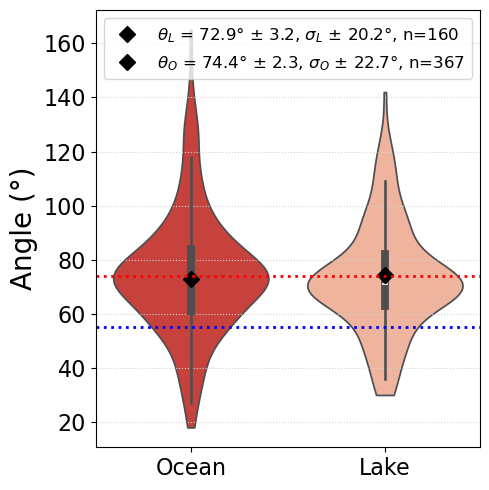

In [12]:
#Figure 7c 

# Copy relevant columns
AData_combined = AData[['Type', 'Angle', 'Hydroclimate', 'Termination']].copy()

# Classify Lake vs Ocean
AData_combined['Waterbody_Type'] = AData_combined['Termination'].apply(
    lambda x: 'Lake' if str(x).strip().lower() == 'lake' else 'Ocean'
)

# Create figure
fig, ax1 = plt.subplots(figsize=(5, 5))

# Bottom Plot: Lake vs Ocean
termination_data = AData_combined[AData_combined['Waterbody_Type'].isin(['Lake', 'Ocean'])]
sns.violinplot(data=termination_data, x='Waterbody_Type', y='Angle',
               palette={'Lake': '#fcae91', 'Ocean': '#de2d26'},
               cut=0, inner='box', ax=ax1)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(['Lake', 'Ocean']):
    group_data = termination_data[termination_data['Waterbody_Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Map to abbreviations for legend subscripts
    abbr = {'Lake': 'L', 'Ocean': 'O'}.get(group, group)
    
    # Plot diamond and collect handle
    handle = ax1.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripts and sample size
    label = rf'$\theta_{{{abbr}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{abbr}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Horizontal lines for delta and fan averages
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
ax1.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
ax1.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)

# Format plot to match Delta Types and Arctic/Non-Arctic
ax1.set_ylabel('Angle (°)', fontsize=20)
ax1.set_xlabel('', fontsize=24)
ax1.set_title('', fontsize=24)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xticklabels(
    [f"{t}"
     for t in termination_data['Waterbody_Type'].unique()],
    rotation=0, ha='center', fontsize=16
)
ax1.legend(handles, labels, fontsize=12, loc='upper center')
ax1.grid(axis='y', linestyle=':', color='lightgrey')

plt.tight_layout()
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\4210476748.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=fan_data, x='Type', y='Angle', palette=type_colors, cut=0, inner='box', ax=ax2)
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\4210476748.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f"{t}" for t in fan_data['Type'].unique()],
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\4210476748.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


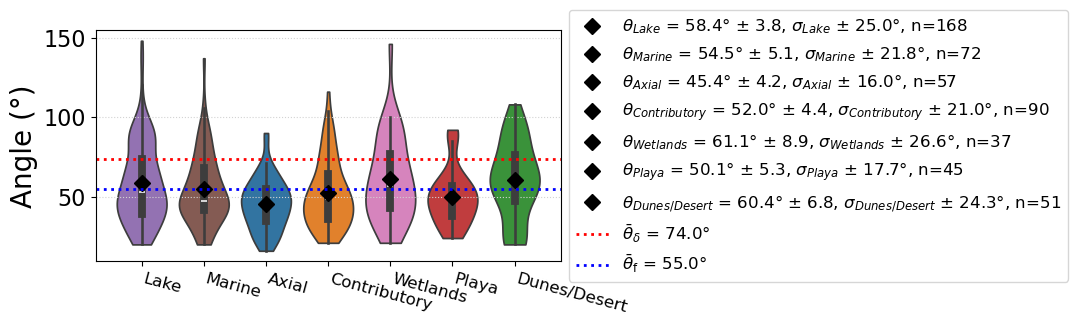

In [12]:
# Figure 7d

# Fluvial Fan Types Plot
fan_data = ADataFan[ADataFan['Type'].isin(['Axial', 'Contributory', 'Dunes/Desert', 'Playa', 'Lake', 'Marine', 'Wetlands'])]

# Check if fan_data is empty
if fan_data.empty:
    print("fan_data is empty. Available types in ADataFan['Type']:", ADataFan['Type'].unique())
    raise ValueError("fan_data is empty. Check ADataFan['Type'] for valid fan types.")

# Define a fallback color palette for all fan types
default_colors = {
    'Axial': '#1f77b4', 'Contributory': '#ff7f0e', 'Dunes/Desert': '#2ca02c',
    'Playa': '#d62728', 'Lake': '#9467bd', 'Marine': '#8c564b', 'Wetlands': '#e377c2'
}
# Use provided type_colors if available and valid, else default_colors
type_colors = type_colors if 'type_colors' in globals() and all(t in type_colors for t in fan_data['Type'].unique()) else default_colors

fig2, ax2 = plt.subplots(figsize=(6, 3))
sns.violinplot(data=fan_data, x='Type', y='Angle', palette=type_colors, cut=0, inner='box', ax=ax2)

# Track handles and labels for custom legend
handles = []
labels = []

# Add mean diamonds and formatted legend entries
for i, group in enumerate(fan_data['Type'].unique()):
    group_data = fan_data[fan_data['Type'] == group]['Angle']
    mean_val = group_data.mean()
    std_val = group_data.std()
    n = len(group_data)
    
    # 95% CI
    ci = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=std_val/np.sqrt(n))
    ci_half_width = (ci[1] - ci[0]) / 2
    
    # Plot diamond and collect handle
    handle = ax2.plot(i, mean_val, marker='D', color='black', markersize=8, linestyle='None')[0]
    
    # Build legend label with subscripts and sample size
    label = rf'$\theta_{{{group}}}$ = {mean_val:.1f}° ± {ci_half_width:.1f}, $\sigma_{{{group}}}$ ± {std_val:.1f}°, n={n}'
    handles.append(handle)
    labels.append(label)

# Add horizontal lines for delta and fan averages with legend entries
avg_delta_angle = AData['Angle'].mean()
avg_fan_angle = ADataFan['Angle'].mean()
line1 = ax2.axhline(avg_delta_angle, color='Red', linestyle=':', linewidth=2)
line2 = ax2.axhline(avg_fan_angle, color='Blue', linestyle=':', linewidth=2)
handles.append(line1)
labels.append(rf'$\bar{{\theta}}_{{\delta}}$ = {avg_delta_angle:.1f}°')
handles.append(line2)
labels.append(rf'$\bar{{\theta}}_{{\mathrm{{f}}}}$ = {avg_fan_angle:.1f}°')

# Update x-tick labels with type counts
type_counts = fan_data['Type'].value_counts()
ax2.set_xticklabels([f"{t}" for t in fan_data['Type'].unique()],
                    rotation=-15, ha='left', fontsize=16)

# Format plot to match Delta Types, Arctic/Non-Arctic, and Lake/Ocean
ax2.set_ylabel('Angle (°)', fontsize=20)
ax2.set_xlabel('', fontsize=12)
ax2.set_title('', fontsize=24)
ax2.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='x', labelsize=12)
ax2.legend(handles, labels, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(axis='y', linestyle=':', color='lightgrey')

plt.tight_layout()
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\3511678047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\3511678047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\3511678047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\3511678047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

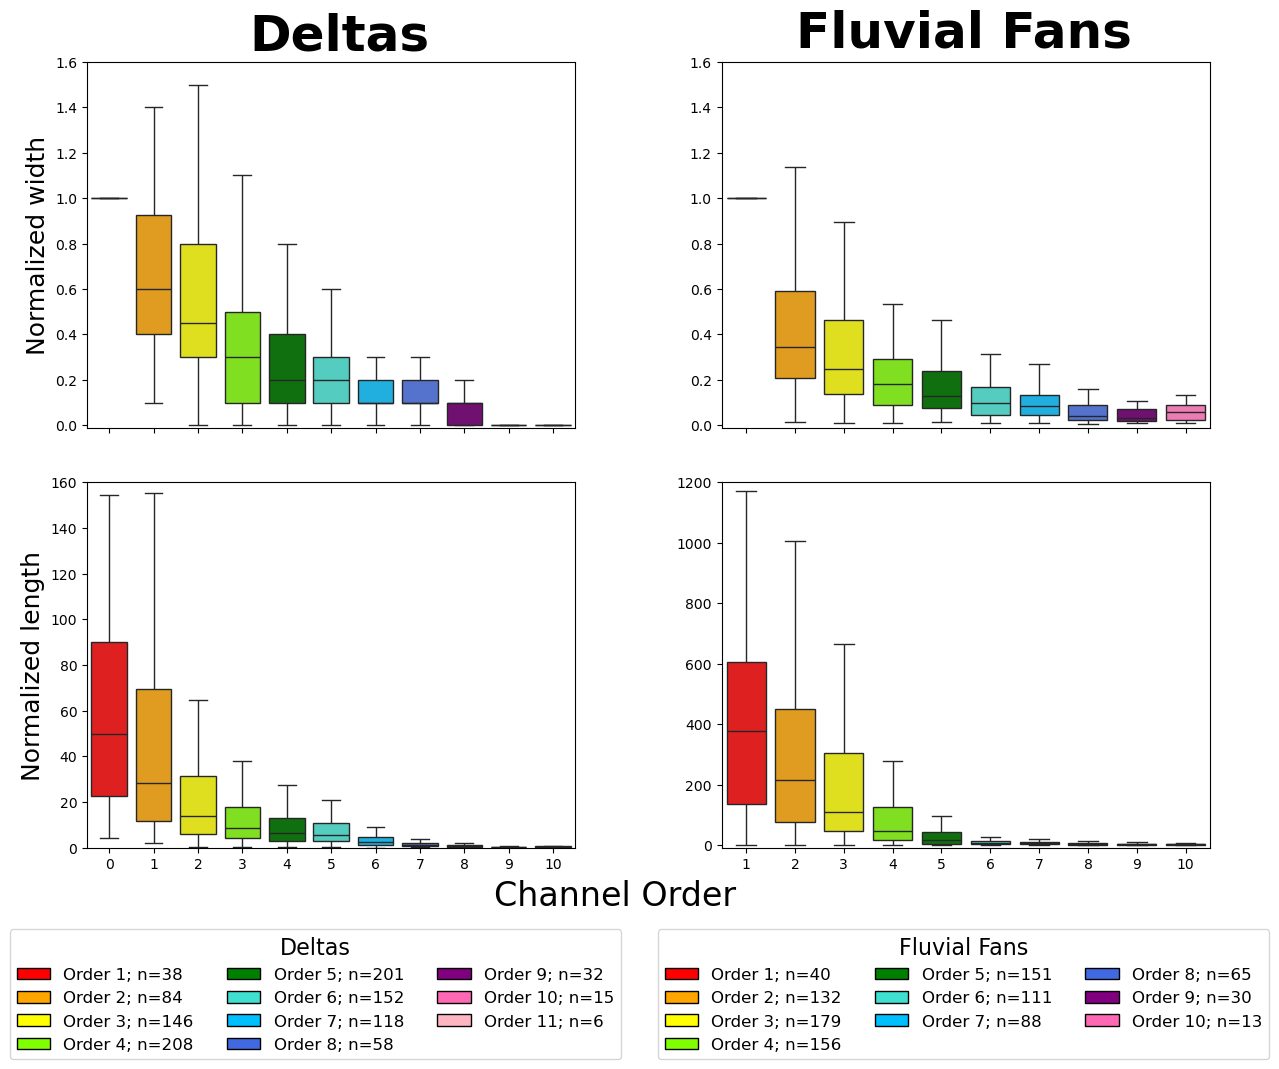

In [13]:
# Figure 8
# --- Custom palette ---
custom_palette = [
    "red", "orange", "yellow", "chartreuse", "green",
    "turquoise", "deepskyblue", "royalblue", "purple", "hotpink", "lightpink"
]

# --- Function to create boxplots ---
def generate_boxplot(ax, x, y, xlabel, ylabel, ylim, order_counts):
    sns.boxplot(
        x=x,
        y=y,
        width=0.8,
        linewidth=1,
        fliersize=0,
        palette=custom_palette[:len(order_counts)],
        data=pd.DataFrame({'x': x, 'y': y}),
        ax=ax
    )
    
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_ylim(ylim)
    ax.set_facecolor('none')
    ax.grid(False)

# --- Count occurrences ---
order_counts_LWData = LWData.ChannelOrder.value_counts().sort_index()
order_counts_LWDataFan = LWDataFan.ChannelOrder.value_counts().sort_index()

# --- 2x2 subplots ---
fig, axs = plt.subplots(2, 2, figsize=(12, 9.5), sharex='col')

# Top row: Widths
generate_boxplot(axs[0, 0], LWData.ChannelOrder, LWData.NormChannelWidth,
                 '', 'Normalized width', (-.01, 1.6), order_counts_LWData)
generate_boxplot(axs[0, 1], LWDataFan.ChannelOrder, LWDataFan.NormChannelWidth,
                 '', '', (-.01, 1.6), order_counts_LWDataFan)

# Bottom row: Lengths
generate_boxplot(axs[1, 0], LWData.ChannelOrder, LWData.NormChannelLength,
                 '', 'Normalized length', (-.1, 160), order_counts_LWData)
generate_boxplot(axs[1, 1], LWDataFan.ChannelOrder, LWDataFan.NormChannelLength,
                 '', '', (-10, 1200), order_counts_LWDataFan)

# Remove top row x-axis labels
for ax in axs[0, :]:
    ax.set_xlabel("")
# Remove right column y-axis labels
for ax in axs[:, 1]:
    ax.set_ylabel("")

# Format x-axis ticks to remove ".0"
def remove_decimal_zero(x, pos):
    return f'{int(x)}'
for ax in axs[:, 0]:
    ax.xaxis.set_major_formatter(FuncFormatter(remove_decimal_zero))

# Central x-axis label
fig.text(0.5, .05, 'Channel Order', ha='center', fontsize=24)

# --- Column group labels ---
fig.text(0.27, 0.94, "Deltas", ha='center', va='bottom', fontsize=36, fontweight="bold")
fig.text(0.79, 0.943, "Fluvial Fans", ha='center', va='bottom', fontsize=36, fontweight="bold")

# --- Build legends ---
legend_labels_deltas = [
    Patch(facecolor=color, edgecolor='black', linewidth=1,
          label=f'Order {int(order)}; n={int(count)}')
    for color, (order, count) in zip(custom_palette, zip(order_counts_LWData.index, order_counts_LWData))
]

legend_labels_fans = [
    Patch(facecolor=color, edgecolor='black', linewidth=1,
          label=f'Order {int(order)}; n={int(count)}')
    for color, (order, count) in zip(custom_palette, zip(order_counts_LWDataFan.index, order_counts_LWDataFan))
]

# Place legends below figure
fig.legend(handles=legend_labels_deltas, title="Deltas",
           fontsize=12, title_fontsize=16,
           loc="lower center", bbox_to_anchor=(0.25, -0.12), ncol=3)

fig.legend(handles=legend_labels_fans, title="Fluvial Fans",
           fontsize=12, title_fontsize=16,
           loc="lower center", bbox_to_anchor=(0.79, -0.12), ncol=3)

# Adjust layout to leave space at top/bottom
plt.tight_layout(pad=0.4, rect=[0, 0.08, 1, 0.95])
plt.subplots_adjust(hspace=0.15, wspace=0.3)

# --- Show final figure ---
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\3827457961.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


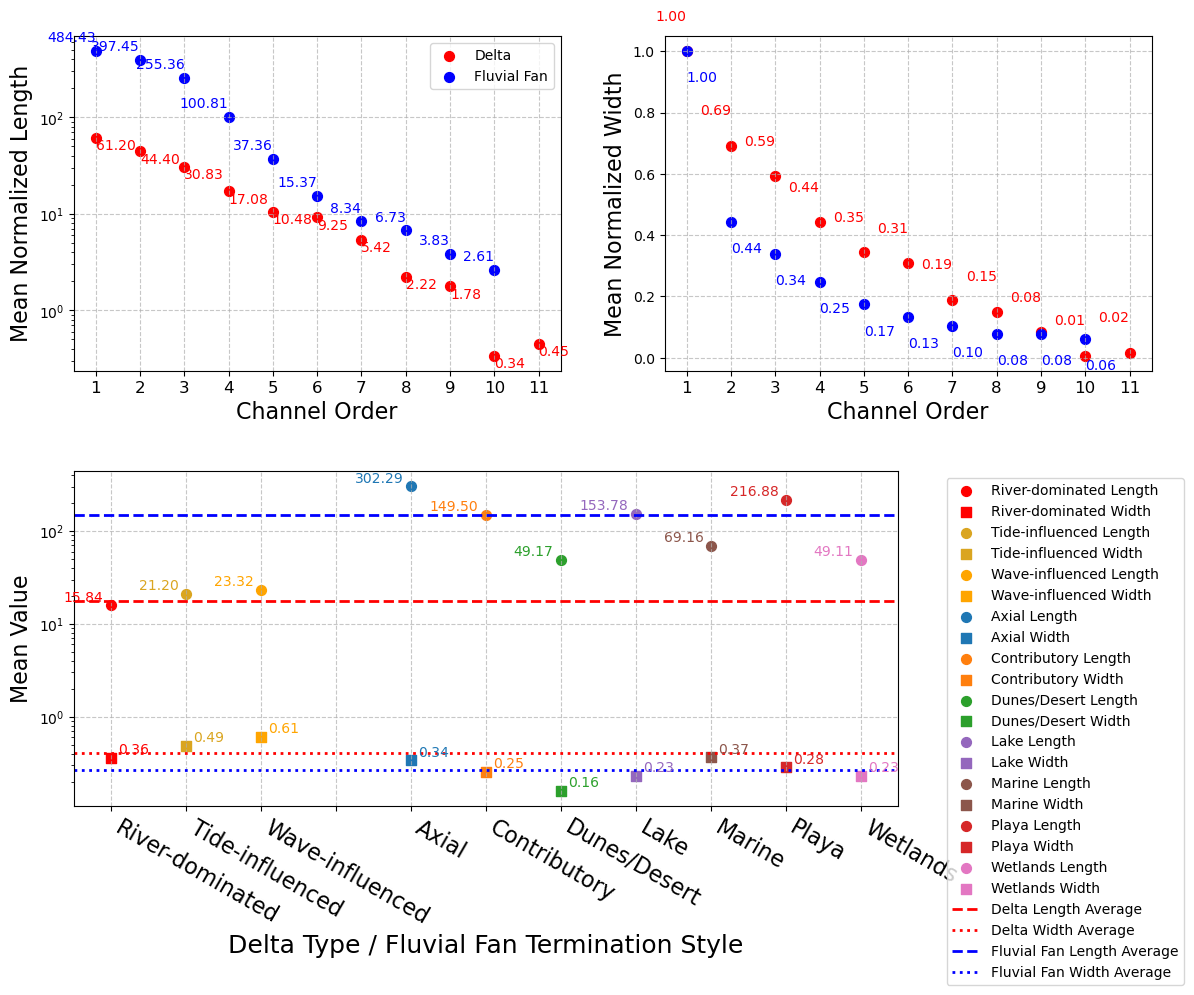

In [14]:
# Figure 9

# --- Compute Means by Channel Order ---
delta_order_means = LWData.groupby('ChannelOrder').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
delta_order_means.columns = ['ChannelOrder', 'Mean Length', 'Mean Width']

fan_order_means = LWDataFan.groupby('ChannelOrder').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
fan_order_means.columns = ['ChannelOrder', 'Mean Length', 'Mean Width']

# Ensure numeric type for sorting
delta_order_means['ChannelOrder'] = pd.to_numeric(delta_order_means['ChannelOrder'], errors='coerce')
fan_order_means['ChannelOrder'] = pd.to_numeric(fan_order_means['ChannelOrder'], errors='coerce')

# Combine all unique orders and sort
all_orders = sorted(set(delta_order_means['ChannelOrder'].dropna()).union(set(fan_order_means['ChannelOrder'].dropna())))

# Overall means
delta_overall_length = LWData['NormChannelLength'].mean()
delta_overall_width = LWData['NormChannelWidth'].mean()
fan_overall_length = LWDataFan['NormChannelLength'].mean()
fan_overall_width = LWDataFan['NormChannelWidth'].mean()

# --- Compute Means by Type/Termination Style ---
# Make sure your DataFrames have a 'Type' column
delta_type_means = LWData.groupby('Type').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
delta_type_means.columns = ['Type', 'Mean Length', 'Mean Width']

fan_type_means = LWDataFan.groupby('Type').agg({
    'NormChannelLength': 'mean',
    'NormChannelWidth': 'mean'
}).reset_index()
fan_type_means.columns = ['Type', 'Mean Length', 'Mean Width']

# --- Define Colors ---
delta_colors = {
    'River-dominated': 'red',
    'Wave-influenced': 'orange',
    'Tide-influenced': '#DAA520'
}

fan_colors = {
    'Axial': '#1f77b4',
    'Contributory': '#ff7f0e',
    'Dunes/Desert': '#2ca02c',
    'Playa': '#d62728',
    'Lake': '#9467bd',
    'Marine': '#8c564b',
    'Wetlands': '#e377c2'
}

# --- Set up figure and gridspec ---
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 14, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

ax0 = fig.add_subplot(gs[0, 0:6])
ax1 = fig.add_subplot(gs[0, 7:13])
ax2 = fig.add_subplot(gs[1, 0:10])

# --- Top Left: Mean Length by Channel Order ---
ax0.scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Length'], color='red', label='Delta', s=50)
ax0.scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Length'], color='blue', label='Fluvial Fan', s=50)
ax0.set_xlabel('Channel Order', fontsize=16)
ax0.set_ylabel('Mean Normalized Length', fontsize=16)
ax0.set_yscale('log')
ax0.grid(True, linestyle='--', alpha=0.7)
ax0.set_xticks(all_orders)
ax0.set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)
ax0.legend(fontsize=10)

# Annotate length values
for _, row in delta_order_means.iterrows():
    ax0.text(row['ChannelOrder'], row['Mean Length'] * 0.75, f"{row['Mean Length']:.2f}", color='red', ha='left', fontsize=10)
for _, row in fan_order_means.iterrows():
    ax0.text(row['ChannelOrder'], row['Mean Length'] * 1.25, f"{row['Mean Length']:.2f}", color='blue', ha='right', fontsize=10)

# --- Top Right: Mean Width by Channel Order ---
ax1.scatter(delta_order_means['ChannelOrder'], delta_order_means['Mean Width'], color='red', s=50)
ax1.scatter(fan_order_means['ChannelOrder'], fan_order_means['Mean Width'], color='blue', s=50)
ax1.set_xlabel('Channel Order', fontsize=16)
ax1.set_ylabel('Mean Normalized Width', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xticks(all_orders)
ax1.set_xticklabels([str(int(o)) for o in all_orders], fontsize=12)

# Annotate width values
for _, row in delta_order_means.iterrows():
    ax1.text(row['ChannelOrder'], row['Mean Width'] + 0.1, f"{row['Mean Width']:.2f}", color='red', ha='right', fontsize=10)
for _, row in fan_order_means.iterrows():
    ax1.text(row['ChannelOrder'], row['Mean Width'] - 0.1, f"{row['Mean Width']:.2f}", color='blue', ha='left', fontsize=10)

# --- Bottom: Mean by Delta Type / Fan Termination Style ---
delta_types = delta_type_means['Type']
fan_styles = fan_type_means['Type']
all_types = list(delta_types) + [''] + list(fan_styles)
x_positions = np.arange(len(all_types))

added_labels = set()

# Plot delta types
for i, row in delta_type_means.iterrows():
    color = delta_colors.get(row['Type'], 'black')
    label_len = f"{row['Type']} Length" if row['Type'] not in added_labels else None
    label_wid = f"{row['Type']} Width" if row['Type'] not in added_labels else None
    ax2.scatter([i], [row['Mean Length']], color=color, marker='o', s=50, label=label_len)
    ax2.scatter([i], [row['Mean Width']], color=color, marker='s', s=50, label=label_wid)
    added_labels.add(row['Type'])

# Plot fan styles (offset)
offset = len(delta_types) + 1
for i, row in fan_type_means.iterrows():
    color = fan_colors.get(row['Type'], 'black')
    label_len = f"{row['Type']} Length" if row['Type'] not in added_labels else None
    label_wid = f"{row['Type']} Width" if row['Type'] not in added_labels else None
    ax2.scatter([i + offset], [row['Mean Length']], color=color, marker='o', s=50, label=label_len)
    ax2.scatter([i + offset], [row['Mean Width']], color=color, marker='s', s=50, label=label_wid)
    added_labels.add(row['Type'])

# Overall mean lines
line_labels = [
    ('Delta Length Average', delta_overall_length, 'red', '--'),
    ('Delta Width Average', delta_overall_width, 'red', ':'),
    ('Fluvial Fan Length Average', fan_overall_length, 'blue', '--'),
    ('Fluvial Fan Width Average', fan_overall_width, 'blue', ':')
]
for lbl, val, color, style in line_labels:
    ax2.axhline(val, color=color, linestyle=style, linewidth=2, label=lbl)

ax2.set_xlabel('Delta Type / Fluvial Fan Termination Style', fontsize=18)
ax2.set_ylabel('Mean Value', fontsize=16)
ax2.set_yscale('log')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(-0.5, len(all_types)-0.5)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(all_types, rotation=330, ha='left', fontsize=16)

# Annotate delta and fan values
for i, row in delta_type_means.iterrows():
    color = delta_colors.get(row['Type'], 'black')
    ax2.text(i - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}", color=color, ha='right', fontsize=10)
    ax2.text(i + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}", color=color, ha='left', fontsize=10)
for i, row in fan_type_means.iterrows():
    color = fan_colors.get(row['Type'], 'black')
    ax2.text(i + offset - 0.1, row['Mean Length'] * 1.1, f"{row['Mean Length']:.2f}", color=color, ha='right', fontsize=10)
    ax2.text(i + offset + 0.1, row['Mean Width'] * 1.1, f"{row['Mean Width']:.2f}", color=color, ha='left', fontsize=10)

# --- Legend for bottom subplot ---
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)

plt.tight_layout()
plt.show()


# Supplementary Material 

In [18]:
# Print unique Type values to confirm
print("Unique Type values in AData:", AData['Type'].unique())

# Subset data for River dominated and Tide-influenced deltas, excluding Wave-influenced
delta_data = AData[AData['Type'].isin(['River dominated', 'Tide-influenced'])]
river_deltas = delta_data[delta_data['Type'] == 'River dominated']
tide_deltas = delta_data[delta_data['Type'] == 'Tide-influenced']

# Check if datasets are sufficient
if len(river_deltas) < 3:
    print(f"Error: River dominated Deltas has {len(river_deltas)} samples, need at least 3.")
if len(tide_deltas) < 3:
    print(f"Error: Tide-influenced Deltas has {len(tide_deltas)} samples, need at least 3.")
if delta_data.empty:
    print("Error: No data for River dominated or Tide-influenced deltas.")
    raise ValueError("delta_data is empty. Check AData['Type'] for valid values.")

# Calculate the overall mean (excluding Wave-influenced)
overall_mean = AData[AData['Type'].isin(['River dominated', 'Tide-influenced'])]['Angle'].mean()
print(f"Overall Mean (River dominated and Tide-influenced): {overall_mean:.2f}")

# Normality tests (Shapiro-Wilk and KS)
def perform_normality_tests(data, name):
    if len(data) < 3:
        print(f"Cannot perform normality tests for {name}: Only {len(data)} samples, need at least 3.\n")
        return
    # Shapiro-Wilk Test
    _, p_value_shapiro = shapiro(data)
    p_status_shapiro = "p < 0.05" if p_value_shapiro < 0.05 else "p > 0.05"
    print(f"Shapiro-Wilk Test for {name}: P-value = {p_value_shapiro:.4f} ({p_status_shapiro})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.")
    
    # KS Test (compare to normal distribution)
    mean = data.mean()
    std = data.std()
    _, p_value_ks = kstest(data, 'norm', args=(mean, std))
    p_status_ks = "p < 0.05" if p_value_ks < 0.05 else "p > 0.05"
    print(f"KS Test for {name}: P-value = {p_value_ks:.4f} ({p_status_ks})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.\n")

# One-sample T-test (compare group mean to overall mean)
def perform_one_sample_t_test(data, overall_mean, name):
    if len(data) < 3:
        print(f"Cannot perform T-test for {name}: Only {len(data)} samples, need at least 3.\n")
        return
    _, p_value_ttest = ttest_1samp(data, overall_mean)
    p_status_ttest = "p < 0.05" if p_value_ttest < 0.05 else "p > 0.05"
    print(f"One-Sample T-Test for {name} vs Overall Mean: P-value = {p_value_ttest:.4f} ({p_status_ttest})")
    print(f"Interpretation: {'Mean is significantly different from the overall mean' if p_value_ttest < 0.05 else 'Mean is not significantly different from the overall mean'}.\n")

# Perform tests for River dominated deltas
print(f"Testing River dominated Deltas (n={len(river_deltas)}):")
perform_normality_tests(river_deltas['Angle'], 'River dominated Deltas')
perform_one_sample_t_test(river_deltas['Angle'], overall_mean, 'River dominated Deltas')

# Perform tests for Tide-influenced deltas
print(f"Testing Tide-influenced Deltas (n={len(tide_deltas)}):")
perform_normality_tests(tide_deltas['Angle'], 'Tide-influenced Deltas')
perform_one_sample_t_test(tide_deltas['Angle'], overall_mean, 'Tide-influenced Deltas')

Unique Type values in AData: ['River dominated' 'Wave-influenced' 'Tide-influenced']
Overall Mean (River dominated and Tide-influenced): 74.15
Testing River dominated Deltas (n=374):
Shapiro-Wilk Test for River dominated Deltas: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for River dominated Deltas: P-value = 0.0002 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

One-Sample T-Test for River dominated Deltas vs Overall Mean: P-value = 0.6418 (p > 0.05)
Interpretation: Mean is not significantly different from the overall mean.

Testing Tide-influenced Deltas (n=139):
Shapiro-Wilk Test for Tide-influenced Deltas: P-value = 0.0337 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for Tide-influenced Deltas: P-value = 0.3173 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

One-Sample T-Test for Tide-influenced Deltas vs Overall Mean: P-value = 0.4711 (p

In [19]:
from scipy.stats import shapiro, kstest, levene, ttest_ind

# Split into non-Arctic (1–5) and Arctic (6) deltas
non_arctic = AData[AData['Hydroclimate'].isin(range(1, 6))]['Angle']
arctic = AData[AData['Hydroclimate'] == 6]['Angle']

print("Sample sizes:")
print(f" Non-Arctic deltas: {len(non_arctic)}")
print(f" Arctic deltas:     {len(arctic)}\n")

# Normality tests
def normality_report(data, name):
    print(f"--- Normality Tests for {name} ---")
    if len(data) < 3:
        print(f" Not enough samples (n={len(data)}) for normality tests.\n")
        return
    
    # Shapiro-Wilk
    _, p_shapiro = shapiro(data)
    print(f" Shapiro-Wilk p-value: {p_shapiro:.4f}  -> {'Non-normal (p<0.05)' if p_shapiro < 0.05 else 'Normal (p>0.05)'}")
    
    # KS against normal with same mean and std
    mean = data.mean()
    std = data.std()
    _, p_ks = kstest(data, 'norm', args=(mean, std))
    print(f" KS Test p-value:      {p_ks:.4f}  -> {'Non-normal (p<0.05)' if p_ks < 0.05 else 'Normal (p>0.05)'}\n")

normality_report(non_arctic, "Non-Arctic deltas")
normality_report(arctic, "Arctic deltas")

# Levene’s test for equal variances
print("--- Levene’s Test for Equal Variances (Non-Arctic vs Arctic) ---")
lev_stat, lev_p = levene(non_arctic, arctic)
print(f" Levene p-value: {lev_p:.4f}  -> {'Variances differ (p<0.05)' if lev_p < 0.05 else 'Variances equal (p>0.05)'}\n")

# Two-sample t-test (choice based on Levene)
print("--- Two-Sample T-Test (Non-Arctic vs Arctic) ---")
equal_var = lev_p > 0.05
t_stat, p_ttest = ttest_ind(non_arctic, arctic, equal_var=equal_var)
print(f" T-test p-value: {p_ttest:.4f}")
if p_ttest < 0.05:
    print(" Interpretation: Means ARE significantly different (p < 0.05).\n")
else:
    print(" Interpretation: Means are NOT significantly different (p > 0.05).\n")

# Summary statistics
print("--- Group Means ---")
print(f" Mean Non-Arctic deltas: {non_arctic.mean():.2f}")
print(f" Mean Arctic deltas:     {arctic.mean():.2f}")


Sample sizes:
 Non-Arctic deltas: 264
 Arctic deltas:     263

--- Normality Tests for Non-Arctic deltas ---
 Shapiro-Wilk p-value: 0.0000  -> Non-normal (p<0.05)
 KS Test p-value:      0.0116  -> Non-normal (p<0.05)

--- Normality Tests for Arctic deltas ---
 Shapiro-Wilk p-value: 0.0000  -> Non-normal (p<0.05)
 KS Test p-value:      0.0032  -> Non-normal (p<0.05)

--- Levene’s Test for Equal Variances (Non-Arctic vs Arctic) ---
 Levene p-value: 0.5783  -> Variances equal (p>0.05)

--- Two-Sample T-Test (Non-Arctic vs Arctic) ---
 T-test p-value: 0.0081
 Interpretation: Means ARE significantly different (p < 0.05).

--- Group Means ---
 Mean Non-Arctic deltas: 71.43
 Mean Arctic deltas:     76.49


In [20]:
from scipy.stats import shapiro, kstest, ttest_1samp, levene, ttest_ind
import pandas as pd
import numpy as np

# Subset only River-dominated and Tide-influenced deltas
delta_data = AData[AData['Type'].isin(['River dominated', 'Tide-influenced'])]
river = delta_data[delta_data['Type'] == 'River dominated']['Angle']
tide = delta_data[delta_data['Type'] == 'Tide-influenced']['Angle']

print("Sample sizes:")
print(f" River-dominated: {len(river)}")
print(f" Tide-influenced: {len(tide)}\n")

# Normality tests
def normality_report(data, name):
    print(f"--- Normality Tests for {name} ---")
    if len(data) < 3:
        print(f" Not enough samples (n={len(data)}) for normality tests.\n")
        return
    
    # Shapiro-Wilk Test
    _, p_shapiro = shapiro(data)
    print(f" Shapiro-Wilk p-value: {p_shapiro:.4f}  -> {'Non-normal (p<0.05)' if p_shapiro < 0.05 else 'Normal (p>0.05)'}")
    
    # Kolmogorov-Smirnov Test
    mean = data.mean()
    std = data.std()
    _, p_ks = kstest(data, 'norm', args=(mean, std))
    print(f" KS Test p-value:      {p_ks:.4f}  -> {'Non-normal (p<0.05)' if p_ks < 0.05 else 'Normal (p>0.05)'}\n")

normality_report(river, "River-dominated deltas")
normality_report(tide, "Tide-influenced deltas")

# Variance Test: Levene's Test
print("--- Levene’s Test for Equal Variances (River vs Tide) ---")
lev_stat, lev_p = levene(river, tide)
print(f" Levene p-value: {lev_p:.4f}  -> {'Variances differ (p<0.05)' if lev_p < 0.05 else 'Variances equal (p>0.05)'}\n")

# Two-sample T-test (River vs Tide)
print("--- Two-Sample T-Test (River vs Tide) ---")
equal_var = lev_p > 0.05  # Use Levene's result
t_stat, p_ttest = ttest_ind(river, tide, equal_var=equal_var)

print(f" T-test p-value: {p_ttest:.4f}")
if p_ttest < 0.05:
    print(" Interpretation: Means ARE significantly different (p < 0.05).\n")
else:
    print(" Interpretation: Means are NOT significantly different (p > 0.05).\n")

# Summary of group means
print("--- Group Means ---")
print(f" Mean River-dominated: {river.mean():.2f}")
print(f" Mean Tide-influenced: {tide.mean():.2f}")


Sample sizes:
 River-dominated: 374
 Tide-influenced: 139

--- Normality Tests for River-dominated deltas ---
 Shapiro-Wilk p-value: 0.0000  -> Non-normal (p<0.05)
 KS Test p-value:      0.0002  -> Non-normal (p<0.05)

--- Normality Tests for Tide-influenced deltas ---
 Shapiro-Wilk p-value: 0.0337  -> Non-normal (p<0.05)
 KS Test p-value:      0.3173  -> Normal (p>0.05)

--- Levene’s Test for Equal Variances (River vs Tide) ---
 Levene p-value: 0.3220  -> Variances equal (p>0.05)

--- Two-Sample T-Test (River vs Tide) ---
 T-test p-value: 0.3789
 Interpretation: Means are NOT significantly different (p > 0.05).

--- Group Means ---
 Mean River-dominated: 73.62
 Mean Tide-influenced: 75.55


In [21]:
from scipy.stats import shapiro, kstest, levene, ttest_ind
import pandas as pd

# Merge 'AData' with 'df' to include lake/ocean classification
merged_data = AData.merge(df[['Name', 'Lake']], on='Name', how='inner')

# Subset for lake- and ocean-terminating deltas
lake = merged_data[merged_data['Lake'] == 'Lake']['Angle']
ocean = merged_data[merged_data['Lake'] == 'Ocean']['Angle']

print("Sample sizes:")
print(f" Lake-terminating deltas:  n = {len(lake)}")
print(f" Ocean-terminating deltas: n = {len(ocean)}\n")

# Normality test (Shapiro-Wilk + KS Test)
def normality_report(data, name):
    print(f"--- Normality Tests for {name} ---")
    if len(data) < 3:
        print(f" Not enough samples (n={len(data)}) for normality tests.\n")
        return

    # Shapiro-Wilk
    _, p_shapiro = shapiro(data)
    print(f" Shapiro-Wilk p-value: {p_shapiro:.4f}  -> "
          f"{'Non-normal (p<0.05)' if p_shapiro < 0.05 else 'Normal (p>0.05)'}")

    # KS test: compare to normal with same mean and std
    mean = data.mean()
    std = data.std()
    _, p_ks = kstest(data, 'norm', args=(mean, std))
    print(f" KS Test p-value:      {p_ks:.4f}  -> "
          f"{'Non-normal (p<0.05)' if p_ks < 0.05 else 'Normal (p>0.05)'}\n")

# Run normality tests
normality_report(lake, "Lake-terminating deltas")
normality_report(ocean, "Ocean-terminating deltas")

# Variance test (Levene's Test)
print("--- Levene’s Test for Equal Variances (Lake vs Ocean) ---")
lev_stat, lev_p = levene(lake, ocean)
print(f" Levene p-value: {lev_p:.4f}  -> "
      f"{'Variances differ (p<0.05)' if lev_p < 0.05 else 'Variances equal (p>0.05)'}\n")

# Two-sample T-test (use Levene result to choose equal_var)
print("--- Two-Sample T-Test (Lake vs Ocean) ---")
equal_var = lev_p > 0.05
t_stat, p_ttest = ttest_ind(lake, ocean, equal_var=equal_var)
print(f" T-test p-value: {p_ttest:.4f}")
if p_ttest < 0.05:
    print(" Interpretation: Means ARE significantly different (p < 0.05).\n")
else:
    print(" Interpretation: Means are NOT significantly different (p > 0.05).\n")

# Summary stats
print("--- Group Means ---")
print(f" Mean Lake-terminating deltas:  {lake.mean():.2f}")
print(f" Mean Ocean-terminating deltas: {ocean.mean():.2f}")


Sample sizes:
 Lake-terminating deltas:  n = 160
 Ocean-terminating deltas: n = 356

--- Normality Tests for Lake-terminating deltas ---
 Shapiro-Wilk p-value: 0.0003  -> Non-normal (p<0.05)
 KS Test p-value:      0.0055  -> Non-normal (p<0.05)

--- Normality Tests for Ocean-terminating deltas ---
 Shapiro-Wilk p-value: 0.0000  -> Non-normal (p<0.05)
 KS Test p-value:      0.0008  -> Non-normal (p<0.05)

--- Levene’s Test for Equal Variances (Lake vs Ocean) ---
 Levene p-value: 0.2454  -> Variances equal (p>0.05)

--- Two-Sample T-Test (Lake vs Ocean) ---
 T-test p-value: 0.4766
 Interpretation: Means are NOT significantly different (p > 0.05).

--- Group Means ---
 Mean Lake-terminating deltas:  72.90
 Mean Ocean-terminating deltas: 74.38


In [22]:
from scipy.stats import shapiro, kstest, levene, ttest_1samp
import pandas as pd
import numpy as np

# Calculate overall fluvial fan mean
avg_fan_angle = ADataFan['Angle'].mean()
print(f"Overall Fluvial Fan Mean: {avg_fan_angle:.2f}")

# Count samples per fan type
fan_types = ADataFan['Type'].unique()
print(f"Fan Types: {fan_types}")
type_counts = ADataFan['Type'].value_counts()

# Filter fan types with 30 or more measurements (optional, based on prior landform analysis)
valid_fan_types = type_counts[type_counts >= 30].index.tolist()
print(f"Fan Types with >= 30 measurements: {valid_fan_types}")

# Subset data to valid fan types
fan_data_valid = ADataFan[ADataFan['Type'].isin(valid_fan_types)]

# Normality tests (Shapiro-Wilk and KS)
def perform_normality_tests(data, name):
    # Shapiro-Wilk Test
    _, p_value_shapiro = shapiro(data)
    p_status_shapiro = "p < 0.05" if p_value_shapiro < 0.05 else "p > 0.05"
    print(f"Shapiro-Wilk Test for {name}: P-value = {p_value_shapiro:.4f} ({p_status_shapiro})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.")
    
    # KS Test (compare to normal distribution)
    mean = data.mean()
    std = data.std()
    _, p_value_ks = kstest(data, 'norm', args=(mean, std))
    p_status_ks = "p < 0.05" if p_value_ks < 0.05 else "p > 0.05"
    print(f"KS Test for {name}: P-value = {p_value_ks:.4f} ({p_status_ks})")
    print("Interpretation: A low p-value (< 0.05) suggests non-normality.\n")
    
    return p_value_shapiro, p_value_ks

# Variance test (Levene's Test)
def perform_variance_test(data1, data2, name1, name2):
    _, p_value_levene = levene(data1, data2)
    p_status = "p < 0.05" if p_value_levene < 0.05 else "p > 0.05"
    print(f"Levene's Test for {name1} vs {name2}: P-value = {p_value_levene:.4f} ({p_status})")
    print("Interpretation: A low p-value (< 0.05) suggests unequal variances.\n")
    return p_value_levene

# One-sample T-test (compare fan type mean to overall fan mean)
def perform_one_sample_t_test(data, overall_mean, name):
    _, p_value_ttest = ttest_1samp(data, overall_mean)
    p_status_ttest = "p < 0.05" if p_value_ttest < 0.05 else "p > 0.05"
    print(f"One-Sample T-Test for {name} vs Overall Fan Mean: P-value = {p_value_ttest:.4f} ({p_status_ttest})")
    print(f"Interpretation: {'Mean is significantly different from the overall fan mean' if p_value_ttest < 0.05 else 'Mean is not significantly different from the overall fan mean'}.\n")
    return p_value_ttest

# Initialize results list
results = []

# Perform tests for each valid fan type
for fan_type in valid_fan_types:
    fan_type_data = fan_data_valid[fan_data_valid['Type'] == fan_type]['Angle']
    sample_size = len(fan_type_data)
    print(f"\nTesting {fan_type} (n={sample_size}):")
    
    # Normality tests
    p_value_shapiro, p_value_ks = perform_normality_tests(fan_type_data, fan_type)
    
    # Levene's test (compare variance to all fluvial fans)
    p_value_levene = perform_variance_test(fan_type_data, ADataFan['Angle'], fan_type, "All Fluvial Fans")
    
    # One-sample T-test
    p_value_ttest = perform_one_sample_t_test(fan_type_data, avg_fan_angle, fan_type)
    
    # Store results
    results.append({
        'Fan Type': fan_type,
        'Sample Size (n)': sample_size,
        'Shapiro-Wilk P-value': p_value_shapiro,
        'KS P-value': p_value_ks,
        'Levene P-value': p_value_levene,
        'T-test Mean P-value': p_value_ttest
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Format p-values to 4 decimal places
results_df['Shapiro-Wilk P-value'] = results_df['Shapiro-Wilk P-value'].map('{:.4f}'.format)
results_df['KS P-value'] = results_df['KS P-value'].map('{:.4f}'.format)
results_df['Levene P-value'] = results_df['Levene P-value'].map('{:.4f}'.format)
results_df['T-test Mean P-value'] = results_df['T-test Mean P-value'].map('{:.4f}'.format)

# Description for table
description = """
Statistical Test Results Description:
- Fan Type: Type of fluvial fan (e.g., based on classification).
- Sample Size (n): Number of angle measurements (≥ 30).
- Shapiro-Wilk P-value: Tests normality; p < 0.05 suggests data is non-normal, p > 0.05 suggests data is normal.
- KS P-value: Tests normality; p < 0.05 suggests data is non-normal, p > 0.05 suggests data is normal.
- Levene P-value: Tests if variance differs from all fluvial fans; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- T-test Mean P-value: Tests if fan type mean differs from overall fluvial fan mean; p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
"""

# Print description and table
print(description)
print(results_df.to_string(index=False))

Overall Fluvial Fan Mean: 54.99
Fan Types: ['Lake' 'Marine' 'Axial' 'Contributory' 'Wetlands' 'Playa' 'Dunes/Desert']
Fan Types with >= 30 measurements: ['Lake', 'Contributory', 'Marine', 'Axial', 'Dunes/Desert', 'Playa', 'Wetlands']

Testing Lake (n=168):
Shapiro-Wilk Test for Lake: P-value = 0.0000 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for Lake: P-value = 0.0881 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.

Levene's Test for Lake vs All Fluvial Fans: P-value = 0.1232 (p > 0.05)
Interpretation: A low p-value (< 0.05) suggests unequal variances.

One-Sample T-Test for Lake vs Overall Fan Mean: P-value = 0.0813 (p > 0.05)
Interpretation: Mean is not significantly different from the overall fan mean.


Testing Contributory (n=90):
Shapiro-Wilk Test for Contributory: P-value = 0.0004 (p < 0.05)
Interpretation: A low p-value (< 0.05) suggests non-normality.
KS Test for Contributory: P-value = 0.2271 (p > 0.05)
Interpr

In [23]:
from scipy.stats import shapiro, kstest, levene, ttest_ind

# ---------- Helper functions ----------

def normality_report(data, name):
    """Shapiro + KS normality tests for a single dataset."""
    print(f"--- Normality Tests for {name} ---")
    if len(data) < 3:
        print(f" Not enough samples (n={len(data)}) for normality tests.\n")
        return

    # Shapiro-Wilk
    _, p_shapiro = shapiro(data)
    print(f" Shapiro-Wilk p-value: {p_shapiro:.4f}  -> "
          f"{'Non-normal (p<0.05)' if p_shapiro < 0.05 else 'Normal (p>0.05)'}")

    # KS vs fitted normal
    mean = data.mean()
    std = data.std()
    if std == 0:
        print(" KS Test skipped (std = 0, all values identical).\n")
        return
    _, p_ks = kstest(data, 'norm', args=(mean, std))
    print(f" KS Test p-value:      {p_ks:.4f}  -> "
          f"{'Non-normal (p<0.05)' if p_ks < 0.05 else 'Normal (p>0.05)'}\n")


def levene_report(data1, data2, name1, name2):
    """Levene’s test for equal variances between two groups."""
    print(f"--- Levene’s Test for Equal Variances ({name1} vs {name2}) ---")
    _, p_lev = levene(data1, data2)
    print(f" Levene p-value: {p_lev:.4f}  -> "
          f"{'Variances differ (p<0.05)' if p_lev < 0.05 else 'Variances equal (p>0.05)'}\n")
    return p_lev


def ttest_report(data1, data2, name1, name2, p_lev):
    """Two-sample t-test using Levene result to set equal_var."""
    print(f"--- Two-Sample T-Test ({name1} vs {name2}) ---")
    equal_var = p_lev > 0.05
    t_stat, p_t = ttest_ind(data1, data2, equal_var=equal_var)
    print(f" T-test p-value: {p_t:.4f}  (equal_var={equal_var})")
    if p_t < 0.05:
        print(" Interpretation: Means ARE significantly different (p < 0.05).\n")
    else:
        print(" Interpretation: Means are NOT significantly different (p > 0.05).\n")


def summarize_groups(data1, data2, name1, name2):
    print("--- Group Means ---")
    print(f" Mean {name1}: {data1.mean():.4f}")
    print(f" Mean {name2}: {data2.mean():.4f}\n")


# ---------- ANGLES: Deltas vs Fluvial Fans ----------

print("========== ANGLES: Delta vs Fluvial Fan ==========\n")
delta_angles = AData['Angle']
fan_angles = ADataFan['Angle']

print(f"Sample sizes: deltas n={len(delta_angles)}, fans n={len(fan_angles)}\n")

normality_report(delta_angles, "Delta Angles")
normality_report(fan_angles, "Fluvial Fan Angles")

p_lev_angles = levene_report(delta_angles, fan_angles, "Delta Angles", "Fluvial Fan Angles")
ttest_report(delta_angles, fan_angles, "Delta Angles", "Fluvial Fan Angles", p_lev_angles)
summarize_groups(delta_angles, fan_angles, "Delta Angles", "Fluvial Fan Angles")


# ---------- LENGTHS: Deltas vs Fluvial Fans ----------

print("========== LENGTHS: Delta vs Fluvial Fan ==========\n")
delta_lengths = LWData['NormChannelLength']
fan_lengths = LWDataFan['NormChannelLength']

print(f"Sample sizes: deltas n={len(delta_lengths)}, fans n={len(fan_lengths)}\n")

normality_report(delta_lengths, "Delta Lengths")
normality_report(fan_lengths, "Fluvial Fan Lengths")

p_lev_lengths = levene_report(delta_lengths, fan_lengths, "Delta Lengths", "Fluvial Fan Lengths")
ttest_report(delta_lengths, fan_lengths, "Delta Lengths", "Fluvial Fan Lengths", p_lev_lengths)
summarize_groups(delta_lengths, fan_lengths, "Delta Lengths", "Fluvial Fan Lengths")


# ---------- WIDTHS: Deltas vs Fluvial Fans ----------

print("========== WIDTHS: Delta vs Fluvial Fan ==========\n")
delta_widths = LWData['NormChannelWidth']
fan_widths = LWDataFan['NormChannelWidth']

print(f"Sample sizes: deltas n={len(delta_widths)}, fans n={len(fan_widths)}\n")

normality_report(delta_widths, "Delta Widths")
normality_report(fan_widths, "Fluvial Fan Widths")

p_lev_widths = levene_report(delta_widths, fan_widths, "Delta Widths", "Fluvial Fan Widths")
ttest_report(delta_widths, fan_widths, "Delta Widths", "Fluvial Fan Widths", p_lev_widths)
summarize_groups(delta_widths, fan_widths, "Delta Widths", "Fluvial Fan Widths")


========== ANGLES: Delta vs Fluvial Fan ==========

Sample sizes: deltas n=527, fans n=520

--- Normality Tests for Delta Angles ---
 Shapiro-Wilk p-value: 0.0000  -> Non-normal (p<0.05)
 KS Test p-value:      0.0000  -> Non-normal (p<0.05)

--- Normality Tests for Fluvial Fan Angles ---
 Shapiro-Wilk p-value: 0.0000  -> Non-normal (p<0.05)
 KS Test p-value:      0.0008  -> Non-normal (p<0.05)

--- Levene’s Test for Equal Variances (Delta Angles vs Fluvial Fan Angles) ---
 Levene p-value: 0.0201  -> Variances differ (p<0.05)

--- Two-Sample T-Test (Delta Angles vs Fluvial Fan Angles) ---
 T-test p-value: 0.0000  (equal_var=False)
 Interpretation: Means ARE significantly different (p < 0.05).

--- Group Means ---
 Mean Delta Angles: 73.9584
 Mean Fluvial Fan Angles: 54.9942

========== LENGTHS: Delta vs Fluvial Fan ==========

Sample sizes: deltas n=1058, fans n=965

--- Normality Tests for Delta Lengths ---
 Shapiro-Wilk p-value: 0.0000  -> Non-normal (p<0.05)
 KS Test p-value:      0.

In [24]:
from scipy.stats import shapiro, ks_2samp, levene, ttest_ind, ttest_rel

# Function to perform normality test and return the result
def perform_normality_test(data1, data2, name1, name2):
    _, p_value_shapiro1 = shapiro(data1)
    _, p_value_shapiro2 = shapiro(data2)
    _, p_value_ks = ks_2samp(data1, data2)
    
    print(f"===== Testing for Normality =====")
    print(f"Normality Test for {name1}: P-value (Shapiro-Wilk) = {p_value_shapiro1:.4f}")
    print(f"Normality Test for {name2}: P-value (Shapiro-Wilk) = {p_value_shapiro2:.4f}")
    print(f"Kolmogorov-Smirnov Test: P-value = {p_value_ks:.4f}")
    print("Interpretation: A low p-value (< 0.05) suggests that the data may not be normally distributed.")
    print("\n")

# Function to perform Levene's test and return the result
def perform_variance_test(data1, data2, name1, name2):
    _, p_value_levene = levene(data1, data2)
    
    print(f"===== Testing for Variances =====")
    print(f"Levene's Test for {name1} and {name2}: P-value = {p_value_levene:.4f}")
    print("Interpretation: A low p-value (< 0.05) suggests that the population variances are significantly different.")
    print("\n")

# Function to perform t-test (either independent or paired) and return the result
def perform_t_test(data1, data2, name1, name2, paired=False):
    if paired:
        _, p_value_ttest = ttest_rel(data1, data2)
        print(f"Paired T-Test for {name1} and {name2}: P-value = {p_value_ttest:.4f}")
    else:
        _, p_value_ttest = ttest_ind(data1, data2, equal_var=True)
        print(f"Independent Samples T-Test for {name1} and {name2} (Assuming Equal Variances): P-value = {p_value_ttest:.4f}")
        print("Interpretation: A low p-value (< 0.05) suggests that the means are significantly different.")
        
        _, p_value_ttest_welch = ttest_ind(data1, data2, equal_var=False)
        print(f"Welch's T-Test for {name1} and {name2} (Unequal Variances): P-value = {p_value_ttest_welch:.4f}")
        print("Interpretation: A low p-value (< 0.05) suggests that the means are significantly different.")
    
    print("\n")

# Assuming you have DataFrame variables AData and ADataFan containing the relevant data columns

# Perform tests for angles
perform_normality_test(AData['Angle'], ADataFan['Angle'], 'Delta Angles', 'Fluvial Fan Angles')
perform_variance_test(AData['Angle'], ADataFan['Angle'], 'Delta Angles', 'Fluvial Fan Angles')
perform_t_test(AData['Angle'], ADataFan['Angle'], 'Delta Angles', 'Fluvial Fan Angles')

# Perform tests for lengths
perform_normality_test(LWData['NormChannelLength'], LWDataFan['NormChannelLength'], 'Delta Lengths', 'Fluvial Fan Lengths')
perform_variance_test(LWData['NormChannelLength'], LWDataFan['NormChannelLength'], 'Delta Lengths', 'Fluvial Fan Lengths')
perform_t_test(LWData['NormChannelLength'], LWDataFan['NormChannelLength'], 'Delta Lengths', 'Fluvial Fan Lengths')

# Perform tests for widths
perform_normality_test(LWData['NormChannelWidth'], LWDataFan['NormChannelWidth'], 'Delta Widths', 'Fluvial Fan Widths')
perform_variance_test(LWData['NormChannelWidth'], LWDataFan['NormChannelWidth'], 'Delta Widths', 'Fluvial Fan Widths')
perform_t_test(LWData['NormChannelWidth'], LWDataFan['NormChannelWidth'], 'Delta Widths', 'Fluvial Fan Widths')

===== Testing for Normality =====
Normality Test for Delta Angles: P-value (Shapiro-Wilk) = 0.0000
Normality Test for Fluvial Fan Angles: P-value (Shapiro-Wilk) = 0.0000
Kolmogorov-Smirnov Test: P-value = 0.0000
Interpretation: A low p-value (< 0.05) suggests that the data may not be normally distributed.


===== Testing for Variances =====
Levene's Test for Delta Angles and Fluvial Fan Angles: P-value = 0.0201
Interpretation: A low p-value (< 0.05) suggests that the population variances are significantly different.


Independent Samples T-Test for Delta Angles and Fluvial Fan Angles (Assuming Equal Variances): P-value = 0.0000
Interpretation: A low p-value (< 0.05) suggests that the means are significantly different.
Welch's T-Test for Delta Angles and Fluvial Fan Angles (Unequal Variances): P-value = 0.0000
Interpretation: A low p-value (< 0.05) suggests that the means are significantly different.


===== Testing for Normality =====
Normality Test for Delta Lengths: P-value (Shapiro-

In [43]:
# Define the check_normality function
def check_normality(p_value):
    return "Normal" if p_value > 0.05 else "Not Normal"

# Function to perform normality tests
def perform_normality_test(data, overall_mean, group, measurement_type):
    if len(data) < 3:
        return {
            'Group': group,
            'Measurement Type': measurement_type,
            'KS P-Value': None,
            'KS Normality': 'Insufficient data',
            'SW P-Value': None,
            'SW Normality': 'Insufficient data'
        }
    ks_test_result = kstest(data, 'norm', args=(overall_mean, data.std()))
    shapiro_test_result = shapiro(data)
    return {
        'Group': group,
        'Measurement Type': measurement_type,
        'KS P-Value': ks_test_result.pvalue,
        'KS Normality': check_normality(ks_test_result.pvalue),
        'SW P-Value': shapiro_test_result.pvalue,
        'SW Normality': check_normality(shapiro_test_result.pvalue)
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, group1, group2, measurement_type):
    if len(data1) < 3 or len(data2) < 3:
        return {
            'Group': f"{group1} vs {group2}",
            'Measurement Type': measurement_type,
            'Levene P-Value': None,
            'Levene Result': 'Insufficient data',
            'T P-Value': None,
            'T Result': 'Insufficient data',
            'T-Test Type': 'None'
        }
    # Levene's test for equality of variances
    _, p_value_levene = levene(data1, data2)
    
    # Independent t-test or Welch's t-test based on Levene's test result
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
        t_test_type = "Welch's t-test"
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
        t_test_type = "Independent t-test"
    
    return {
        'Group': f"{group1} vs {group2}",
        'Measurement Type': measurement_type,
        'Levene P-Value': p_value_levene,
        'Levene Result': "Reject" if p_value_levene < 0.05 else "Fail to reject",
        'T P-Value': p_value_t,
        'T Result': "Reject" if p_value_t < 0.05 else "Fail to reject",
        'T-Test Type': t_test_type
    }

# Calculate overall means for normality tests and comparisons
overall_mean_length_delta = LWData['NormChannelLength'].mean()
overall_mean_width_delta = LWData['NormChannelWidth'].mean()
overall_mean_length_fan = LWDataFan['NormChannelLength'].mean()
overall_mean_width_fan = LWDataFan['NormChannelWidth'].mean()

# Initialize results list
results = []

# Perform normality tests for deltas
results.append(perform_normality_test(LWData['NormChannelLength'], overall_mean_length_delta, 'Delta', 'Length'))
results.append(perform_normality_test(LWData['NormChannelWidth'], overall_mean_width_delta, 'Delta', 'Width'))

# Perform normality tests for fluvial fans
results.append(perform_normality_test(LWDataFan['NormChannelLength'], overall_mean_length_fan, 'Fluvial Fan', 'Length'))
results.append(perform_normality_test(LWDataFan['NormChannelWidth'], overall_mean_width_fan, 'Fluvial Fan', 'Width'))

# Perform variance and t-tests for length and width
length_comparison = perform_tests(LWData['NormChannelLength'], LWDataFan['NormChannelLength'], 'Delta', 'Fluvial Fan', 'Length')
width_comparison = perform_tests(LWData['NormChannelWidth'], LWDataFan['NormChannelWidth'], 'Delta', 'Fluvial Fan', 'Width')
results.append(length_comparison)
results.append(width_comparison)

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values to 4 decimal places where applicable
for col in ['KS P-Value', 'SW P-Value', 'Levene P-Value', 'T P-Value']:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else 'N/A')

# Fill NaN for non-applicable columns
results_df = results_df.fillna('N/A')

# Select key columns for clarity
results_df = results_df[['Group', 'Measurement Type', 'KS P-Value', 'KS Normality', 'SW P-Value', 'SW Normality', 
                         'Levene P-Value', 'Levene Result', 'T P-Value', 'T Result', 'T-Test Type']]

# Description for table
description = """
Statistical Test Results Description:
- Group: Delta, Fluvial Fan, or comparison (Delta vs Fluvial Fan).
- Measurement Type: Channel Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value: Tests normality; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- KS Normality: Normal (p > 0.05) or Not Normal (p < 0.05).
- SW P-Value: Tests normality; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- SW Normality: Normal (p > 0.05) or Not Normal (p < 0.05).
- Levene P-Value: Tests if variances differ; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- Levene Result: Reject (p < 0.05, unequal variances) or Fail to reject (p > 0.05, equal variances).
- T P-Value: Tests if means differ; p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
- T Result: Reject (p < 0.05, means differ) or Fail to reject (p > 0.05, means similar).
- T-Test Type: Independent t-test (equal variances) or Welch's t-test (unequal variances).
"""

# Custom function to print table with separating lines
def print_table_with_lines(df):
    # Define column widths for alignment
    col_widths = {
        'Group': 20,
        'Measurement Type': 15,
        'KS P-Value': 12,
        'KS Normality': 12,
        'SW P-Value': 12,
        'SW Normality': 12,
        'Levene P-Value': 15,
        'Levene Result': 15,
        'T P-Value': 12,
        'T Result': 15,
        'T-Test Type': 15
    }
    
    # Header
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
    print(description)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    
    # Rows with separators
    last_group = None
    for _, row in df.iterrows():
        if last_group is not None and row['Group'] != last_group:
            print('-' * len(header))
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
        print(row_str)
        last_group = row['Group']
    
    print('-' * len(header))

# Print table
print_table_with_lines(results_df)

# Summary of means
length_similarity = "similar" if length_comparison['T P-Value'] >= 0.05 else "not similar"
width_similarity = "similar" if width_comparison['T P-Value'] >= 0.05 else "not similar"
length_larger = "deltas" if overall_mean_length_delta > overall_mean_length_fan else "fluvial fans"
width_larger = "deltas" if overall_mean_width_delta > overall_mean_width_fan else "fluvial fans"

print("\nMean Comparison Summary:")
print(f"The delta and fluvial fan length means are {length_similarity}, with {length_larger} having a larger mean "
      f"(Delta: {overall_mean_length_delta:.2f}, Fluvial Fan: {overall_mean_length_fan:.2f}).")
print(f"The delta and fluvial fan width means are {width_similarity}, with {width_larger} having a larger mean "
      f"(Delta: {overall_mean_width_delta:.2f}, Fluvial Fan: {overall_mean_width_fan:.2f}).")


Statistical Test Results Description:
- Group: Delta, Fluvial Fan, or comparison (Delta vs Fluvial Fan).
- Measurement Type: Channel Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value: Tests normality; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- KS Normality: Normal (p > 0.05) or Not Normal (p < 0.05).
- SW P-Value: Tests normality; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- SW Normality: Normal (p > 0.05) or Not Normal (p < 0.05).
- Levene P-Value: Tests if variances differ; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- Levene Result: Reject (p < 0.05, unequal variances) or Fail to reject (p > 0.05, equal variances).
- T P-Value: Tests if means differ; p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
- T Result: Reject (p < 0.05, means differ) or Fail to reject (p > 0.05, means similar).
- T-Test Type: Independent t-test (equal variances) or Welch's t-test (unequal varia

In [42]:
# --------- 1. Helpers ---------

def normality_pvalues(data):
    """Return SW and KS p-values for one group."""
    if len(data) < 3:
        return None, None
    sw_p = shapiro(data).pvalue
    ks_p = kstest(data, 'norm', args=(data.mean(), data.std())).pvalue
    return sw_p, ks_p

def levene_and_ttest(delta_data, fan_data):
    """Return Levene p and t-test p (Welch if Levene < 0.05)."""
    if len(delta_data) < 3 or len(fan_data) < 3:
        return None, None
    lev_p = levene(delta_data, fan_data).pvalue
    equal_var = lev_p >= 0.05
    t_p = ttest_ind(delta_data, fan_data, equal_var=equal_var).pvalue
    return lev_p, t_p

# --------- 2. Build results per order + measurement ---------

order_column = 'ChannelOrder'
orders = set(LWData[order_column].unique()).intersection(LWDataFan[order_column].unique())
measurements = ['NormChannelLength', 'NormChannelWidth']  # Lengths first, then widths

results = []

print("Orders present in BOTH datasets:", sorted(orders))

for measurement in measurements:
    meas_label = measurement.replace('NormChannel', '')  # "Length" or "Width"
    print(f"\n=== Measurement: {meas_label} ===")
    for order in sorted(orders):
        delta_data = LWData[LWData[order_column] == order][measurement]
        fan_data   = LWDataFan[LWDataFan[order_column] == order][measurement]

        n_delta = len(delta_data)
        n_fan   = len(fan_data)
        print(f"Order {order}: Delta n={n_delta}, Fan n={n_fan}")

        # Require n >= 30 for both groups
        if n_delta >= 30 and n_fan >= 30:
            # Normality for each group
            sw_delta, ks_delta = normality_pvalues(delta_data)
            sw_fan,   ks_fan   = normality_pvalues(fan_data)

            # Levene + t-test for this order & measurement
            lev_p, t_p = levene_and_ttest(delta_data, fan_data)

            # Row for Delta
            results.append({
                'Measurement': meas_label,
                'Order': order,
                'Group': 'Delta',
                'n': n_delta,
                'SW P-Value': sw_delta,
                'KS P-Value': ks_delta,
                'Levene P-Value': lev_p,
                'T P-Value': t_p
            })

            # Row for Fan
            results.append({
                'Measurement': meas_label,
                'Order': order,
                'Group': 'Fluvial Fan',
                'n': n_fan,
                'SW P-Value': sw_fan,
                'KS P-Value': ks_fan,
                'Levene P-Value': lev_p,
                'T P-Value': t_p
            })
        else:
            print(f"  -> Omitted (requires n >= 30 for BOTH).")

results_df = pd.DataFrame(results)
print("\nNumber of rows in results_df:", len(results_df))

if results_df.empty:
    print("\nNo comparisons meet the n >= 30 requirement. Nothing to print.")
else:
    # --------- 3. Formatting p-values and ordering rows/columns ---------

    def format_p(p):
        if pd.isnull(p):
            return "N/A"
        return f"{float(p):.4f}"

    # Sort rows: Length first, then Width; within each, by Order, then Group (Delta, Fluvial Fan)
    results_df['Measurement'] = pd.Categorical(results_df['Measurement'],
                                               categories=['Length', 'Width'],
                                               ordered=True)
    results_df['Group'] = pd.Categorical(results_df['Group'],
                                         categories=['Delta', 'Fluvial Fan'],
                                         ordered=True)

    results_df = results_df.sort_values(['Measurement', 'Order', 'Group'])

    # Format p-values
    for col in ['SW P-Value', 'KS P-Value', 'Levene P-Value', 'T P-Value']:
        results_df[col] = results_df[col].apply(format_p)

    # Desired column order: SW, then KS, then Levene, then T
    final_cols = ['Measurement', 'Order', 'Group', 'n',
                  'SW P-Value', 'KS P-Value', 'Levene P-Value', 'T P-Value']
    results_df = results_df[final_cols]

    # --------- 4. Pretty printing ---------

    def print_table_with_lines(df):
        col_widths = {
            'Measurement': 12,
            'Order': 8,
            'Group': 12,
            'n': 6,
            'SW P-Value': 12,
            'KS P-Value': 12,
            'Levene P-Value': 15,
            'T P-Value': 12
        }
        description = """
Statistical Test Results Description:
- Rows: For each Measurement (Length first, then Width) and each channel Order,
        results are shown for Delta and Fluvial Fan separately.
- SW P-Value: Shapiro–Wilk normality test (per group).
- KS P-Value: Kolmogorov–Smirnov normality test vs fitted normal (per group).
- Levene P-Value: Equality of variances between Delta and Fluvial Fan for that Order + Measurement.
- T P-Value: Delta vs Fluvial Fan mean comparison (Welch used if Levene < 0.05).
- P-values are formatted to 4 decimal places.
- Only orders where both groups have n >= 30 are included.
"""
        header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
        print(description)
        print('-' * len(header))
        print(header)
        print('-' * len(header))
        last_meas = None
        last_order = None
        for _, row in df.iterrows():
            # Optional: add separator between different orders or measurements
            if (last_meas is not None and
                (row['Measurement'] != last_meas or row['Order'] != last_order)):
                print('-' * len(header))
            row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
            print(row_str)
            last_meas = row['Measurement']
            last_order = row['Order']
        print('-' * len(header))

    print("\n\nFormatted results table:\n")
    print_table_with_lines(results_df)


Orders present in BOTH datasets: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

=== Measurement: Length ===
Order 1: Delta n=38, Fan n=40
Order 2: Delta n=84, Fan n=132
Order 3: Delta n=146, Fan n=179
Order 4: Delta n=208, Fan n=156
Order 5: Delta n=201, Fan n=151
Order 6: Delta n=152, Fan n=111
Order 7: Delta n=118, Fan n=88
Order 8: Delta n=58, Fan n=65
Order 9: Delta n=32, Fan n=30
Order 10: Delta n=15, Fan n=13
  -> Omitted (requires n >= 30 for BOTH).

=== Measurement: Width ===
Order 1: Delta n=38, Fan n=40
Order 2: Delta n=84, Fan n=132
Order 3: Delta n=146, Fan n=179
Order 4: Delta n=208, Fan n=156
Order 5: Delta n=201, Fan n=151
Order 6: Delta n=152, Fan n=111
Order 7: Delta n=118, Fan n=88
Order 8: Delta n=58, Fan n=65
Order 9: Delta n=32, Fan n=30
Order 10: Delta n=15, Fan n=13
  -> Omitted (requires n >= 30 for BOTH).

Number of rows in results_df: 36


Formatted results table:


Statistical Test Results Description:
- Rows: For each Measurement (Length first, then Width) and each channe

C:\Users\lukej\anaconda3\envs\fan_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\lukej\anaconda3\envs\fan_env\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2148: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\lukej\anaconda3\envs\fan_env\Lib\site-packages\scipy\stats\_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
C:\Users\lukej\anaconda3\envs\fan_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [26]:
import pandas as pd
from scipy.stats import kstest, shapiro, levene, ttest_ind

# Function to perform normality tests
def perform_normality_test(data, group_name, measurement_type, order):
    if len(data) < 3:
        # Return consistent keys even if not enough samples
        return {
            f'KS P-Value ({group_name})': None,
            f'SW P-Value ({group_name})': None
        }
    ks_test_result = kstest(data, 'norm', args=(data.mean(), data.std()))
    shapiro_test_result = shapiro(data)
    return {
        f'KS P-Value ({group_name})': ks_test_result.pvalue,
        f'SW P-Value ({group_name})': shapiro_test_result.pvalue
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, measurement_type, order):
    if len(data1) < 3 or len(data2) < 3:
        return {'Levene P-Value': None, 'T P-Value': None}
    _, p_value_levene = levene(data1, data2)
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
    return {
        'Levene P-Value': p_value_levene,
        'T P-Value': p_value_t
    }

# Use correct column name
order_column = 'ChannelOrder'

# Get unique orders from both datasets
orders = set(LWData[order_column].unique()).intersection(LWDataFan[order_column].unique())

# Initialize results list
results = []

# Measurements to compare
measurements = ['NormChannelLength', 'NormChannelWidth']

# Perform tests for each order and measurement
for order in sorted(orders):
    for measurement in measurements:
        delta_data = LWData[LWData[order_column] == order][measurement]
        fan_data = LWDataFan[LWDataFan[order_column] == order][measurement]
        if len(delta_data) >= 30 and len(fan_data) >= 30:
            delta_normality = perform_normality_test(delta_data, 'Delta', measurement, order)
            fan_normality = perform_normality_test(fan_data, 'Fan', measurement, order)
            comparison_tests = perform_tests(delta_data, fan_data, measurement, order)
            result = {
                'Order': order,
                'Measurement': measurement.replace('NormChannel', ''),  # Length or Width
                **delta_normality,
                **fan_normality,
                **comparison_tests
            }
            results.append(result)
        else:
            print(
                f"Omitted comparison for Order {order}, {measurement}: "
                f"Delta n={len(delta_data)}, Fan n={len(fan_data)} (requires n >= 30 for both)."
            )

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values as "p > 0.05" or "p < 0.05"
def format_p_value(p):
    if pd.notnull(p):
        return "p > 0.05" if p > 0.05 else "p < 0.05"
    return "N/A"

for col in ['KS P-Value (Delta)', 'SW P-Value (Delta)',
            'KS P-Value (Fan)', 'SW P-Value (Fan)',
            'Levene P-Value', 'T P-Value']:
    results_df[col] = results_df[col].apply(format_p_value)

# Custom function to print table with separating lines
def print_table_with_lines(df):
    col_widths = {
        'Order': 8,
        'Measurement': 12,
        'KS P-Value (Delta)': 15,
        'SW P-Value (Delta)': 15,
        'KS P-Value (Fan)': 15,
        'SW P-Value (Fan)': 15,
        'Levene P-Value': 15,
        'T P-Value': 12
    }
    description = """
Statistical Test Results Description:
- Order: Channel order (e.g., 1 for first-order).
- Measurement: Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value (Delta/Fan): Normality test; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Delta/Fan): Normality test; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison (delta vs fan); p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Only comparisons with n >= 30 for both delta and fan are included.
"""
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
    print(description)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    last_order = None
    for _, row in df.iterrows():
        if last_order is not None and row['Order'] != last_order:
            print('-' * len(header))
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
        print(row_str)
        last_order = row['Order']
    print('-' * len(header))

# Print table
if not results_df.empty:
    print_table_with_lines(results_df)
else:
    print("No comparisons meet the n >= 30 sample size requirement for both delta and fan populations.")


Omitted comparison for Order 10, NormChannelLength: Delta n=15, Fan n=13 (requires n >= 30 for both).
Omitted comparison for Order 10, NormChannelWidth: Delta n=15, Fan n=13 (requires n >= 30 for both).

Statistical Test Results Description:
- Order: Channel order (e.g., 1 for first-order).
- Measurement: Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value (Delta/Fan): Normality test; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Delta/Fan): Normality test; p < 0.05 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p < 0.05 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison (delta vs fan); p < 0.05 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Only comparisons with n >= 30 for both delta and fan are included.

----------------------------------------------------------------------------------------------------------------------------

C:\Users\lukej\anaconda3\envs\fan_env\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2148: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\lukej\anaconda3\envs\fan_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\lukej\anaconda3\envs\fan_env\Lib\site-packages\scipy\stats\_morestats.py:3104: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
C:\Users\lukej\anaconda3\envs\fan_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [28]:
import pandas as pd
from scipy.stats import kstest, shapiro, levene, ttest_ind

# Function to perform normality tests
def perform_normality_test(data, group_name, measurement_type, delta_type):
    if len(data) < 3:
        return {
            f'KS P-Value ({group_name})': None,
            f'SW P-Value ({group_name})': None
        }
    ks_test_result = kstest(data, 'norm', args=(data.mean(), data.std()))
    shapiro_test_result = shapiro(data)
    return {
        f'KS P-Value ({group_name})': ks_test_result.pvalue,
        f'SW P-Value ({group_name})': shapiro_test_result.pvalue
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, measurement_type, delta_type):
    if len(data1) < 3 or len(data2) < 3:
        return {'Levene P-Value': None, 'T P-Value': None}
    _, p_value_levene = levene(data1, data2)
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
    return {
        'Levene P-Value': p_value_levene,
        'T P-Value': p_value_t
    }

# List of delta types
lw_delta_types = LWData['Type'].unique()
adata_delta_types = AData['Type'].unique()

# Overall means (not directly used in this version, but fine to keep)
overall_mean_length = LWData['NormChannelLength'].mean()
overall_mean_width = LWData['NormChannelWidth'].mean()
overall_mean_angle = AData['Angle'].mean()

results = []

# LWData: lengths and widths
for delta_type in lw_delta_types:
    # Lengths
    lengths = LWData.loc[LWData['Type'] == delta_type, 'NormChannelLength']
    if len(lengths) >= 3:
        length_normality = perform_normality_test(lengths, 'Type', 'Length', delta_type)
        length_tests = perform_tests(lengths, LWData['NormChannelLength'], 'Length', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Length',
            **length_normality,
            **length_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Length: n={len(lengths)} (requires n >= 3).")

    # Widths
    widths = LWData.loc[LWData['Type'] == delta_type, 'NormChannelWidth']
    if len(widths) >= 3:
        width_normality = perform_normality_test(widths, 'Type', 'Width', delta_type)
        width_tests = perform_tests(widths, LWData['NormChannelWidth'], 'Width', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Width',
            **width_normality,
            **width_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Width: n={len(widths)} (requires n >= 3).")

# AData: angles
for delta_type in adata_delta_types:
    angles = AData.loc[AData['Type'] == delta_type, 'Angle']
    if len(angles) >= 3:
        angle_normality = perform_normality_test(angles, 'Type', 'Angle', delta_type)
        angle_tests = perform_tests(angles, AData['Angle'], 'Angle', delta_type)
        results.append({
            'Delta Type': delta_type,
            'Measurement': 'Angle',
            **angle_normality,
            **angle_tests
        })
    else:
        print(f"Omitted comparison for {delta_type}, Angle: n={len(angles)} (requires n >= 3).")

# Create DataFrame
results_df = pd.DataFrame(results)

# --- FORMAT P-VALUES AS 4-DECIMAL NUMBERS ---

def format_p_value(p):
    if pd.isnull(p):
        return "N/A"
    return f"{float(p):.4f}"

for col in ['KS P-Value (Type)', 'SW P-Value (Type)', 'Levene P-Value', 'T P-Value']:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(format_p_value)

# Pretty printing
def print_table_with_lines(df):
    col_widths = {
        'Delta Type': 15,
        'Measurement': 12,
        'KS P-Value (Type)': 18,
        'SW P-Value (Type)': 18,
        'Levene P-Value': 15,
        'T P-Value': 12
    }
    description = """
Statistical Test Results Description:
- Delta Type: River-dominated, Wave-influenced, Tide-influenced, or other delta type.
- Measurement: Length (NormChannelLength), Width (NormChannelWidth), or Angle.
- KS P-Value (Type): Kolmogorov–Smirnov normality test vs fitted normal; p < 0.05 suggests non-normality.
- SW P-Value (Type): Shapiro–Wilk normality test; p < 0.05 suggests non-normality.
- Levene P-Value: Equality of variances; p < 0.05 suggests unequal variances.
- T P-Value: Mean comparison between this type and the full population for that measurement.
- P-values are shown as exact values to 4 decimal places.
Note: Compares each delta type against the overall dataset; requires n >= 3.
"""
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
    print(description)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    last_type = None
    for _, row in df.iterrows():
        if last_type is not None and row['Delta Type'] != last_type:
            print('-' * len(header))
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
        print(row_str)
        last_type = row['Delta Type']
    print('-' * len(header))

if not results_df.empty:
    print_table_with_lines(results_df)
else:
    print("No comparisons meet the n >= 3 sample size requirement.")



Statistical Test Results Description:
- Delta Type: River-dominated, Wave-influenced, Tide-influenced, or other delta type.
- Measurement: Length (NormChannelLength), Width (NormChannelWidth), or Angle.
- KS P-Value (Type): Kolmogorov–Smirnov normality test vs fitted normal; p < 0.05 suggests non-normality.
- SW P-Value (Type): Shapiro–Wilk normality test; p < 0.05 suggests non-normality.
- Levene P-Value: Equality of variances; p < 0.05 suggests unequal variances.
- T P-Value: Mean comparison between this type and the full population for that measurement.
- P-values are shown as exact values to 4 decimal places.
Note: Compares each delta type against the overall dataset; requires n >= 3.

---------------------------------------------------------------------------------------------------------
Delta Type      | Measurement  | KS P-Value (Type)  | SW P-Value (Type)  | Levene P-Value  | T P-Value   
----------------------------------------------------------------------------------------

In [44]:
import pandas as pd
from scipy.stats import kstest, shapiro, ttest_1samp, levene

# Define the check_normality function
def check_normality(p_value):
    return "Normal" if p_value > 0.05 else "Not Normal"

# Function to perform normality tests
def perform_normality_test(data, overall_mean, fan_type, measurement_type):
    if len(data) == 0:
        return {
            'Fan Type': fan_type,
            'Measurement Type': measurement_type,
            'KS P-Value': None,
            'KS Normality': 'Insufficient data',
            'SW P-Value': None,
            'SW Normality': 'Insufficient data'
        }
    ks_test_result = kstest(data, 'norm', args=(overall_mean, data.std()))
    shapiro_test_result = shapiro(data)
    return {
        'Fan Type': fan_type,
        'Measurement Type': measurement_type,
        'KS P-Value': ks_test_result.pvalue,
        'KS Normality': check_normality(ks_test_result.pvalue),
        'SW P-Value': shapiro_test_result.pvalue,
        'SW Normality': check_normality(shapiro_test_result.pvalue)
    }

# Function to perform t-tests
def perform_t_test(data, overall_mean, fan_type, measurement_type):
    if len(data) == 0:
        return {
            'Fan Type': fan_type,
            'Measurement Type': measurement_type,
            'T-Test P-Value': None,
            'T-Test Result': 'Insufficient data',
            'Means Similar': 'Insufficient data'
        }
    t_statistic, p_value = ttest_1samp(data, overall_mean)
    means_similar = "Yes" if p_value >= 0.05 else "No"  # If p-value > 0.05, fail to reject, meaning the means are similar
    return {
        'Fan Type': fan_type,
        'Measurement Type': measurement_type,
        'T-Test P-Value': p_value,
        'T-Test Result': "Reject" if p_value < 0.05 else "Fail to reject",
        'Means Similar': means_similar  # Added column for whether the means are similar or not
    }

# Function to perform Levene's test for variance equality
def perform_levene_test(data, overall_data, fan_type, measurement_type):
    if len(data) == 0 or len(overall_data) == 0:
        return {
            'Fan Type': fan_type,
            'Measurement Type': measurement_type,
            'Levene P-Value': None,
            'Levene Result': 'Insufficient data'
        }
    _, p_value_levene = levene(data, overall_data)
    variances_similar = "Yes" if p_value_levene >= 0.05 else "No"
    return {
        'Fan Type': fan_type,
        'Measurement Type': measurement_type,
        'Levene P-Value': p_value_levene,
        'Levene Result': "Fail to reject" if p_value_levene >= 0.05 else "Reject",
        'Variance Similar': variances_similar
    }

# Calculate the overall mean of fan lengths, widths, and angles
overall_mean_length = LWDataFan['NormChannelLength'].mean()
overall_mean_width = LWDataFan['NormChannelWidth'].mean()
overall_mean_angle = ADataFan['Angle'].mean()  # Assuming 'Angle' column is from ADataFan

# Initialize lists to store the test results
length_results = []
width_results = []
angle_results = []

# Perform tests for fan lengths, widths, and angles
fan_types = LWDataFan['Type'].unique()
for fan_type in fan_types:
    # Fan lengths (from LWDataFan)
    lengths = LWDataFan.loc[LWDataFan['Type'] == fan_type, 'NormChannelLength']
    length_results.append(perform_normality_test(lengths, overall_mean_length, fan_type, 'Length'))
    length_results[-1].update(perform_t_test(lengths, overall_mean_length, fan_type, 'Length'))
    length_results[-1].update(perform_levene_test(lengths, LWDataFan['NormChannelLength'], fan_type, 'Length'))
    
    # Fan widths (from LWDataFan)
    widths = LWDataFan.loc[LWDataFan['Type'] == fan_type, 'NormChannelWidth']
    width_results.append(perform_normality_test(widths, overall_mean_width, fan_type, 'Width'))
    width_results[-1].update(perform_t_test(widths, overall_mean_width, fan_type, 'Width'))
    width_results[-1].update(perform_levene_test(widths, LWDataFan['NormChannelWidth'], fan_type, 'Width'))

    # Fan angles (from ADataFan)
    angles = ADataFan.loc[ADataFan['Type'] == fan_type, 'Angle']
    angle_results.append(perform_normality_test(angles, overall_mean_angle, fan_type, 'Angle'))
    angle_results[-1].update(perform_t_test(angles, overall_mean_angle, fan_type, 'Angle'))
    angle_results[-1].update(perform_levene_test(angles, ADataFan['Angle'], fan_type, 'Angle'))

# Create DataFrames from the results lists
length_results_df = pd.DataFrame(length_results)
width_results_df = pd.DataFrame(width_results)
angle_results_df = pd.DataFrame(angle_results)

# Combine the results into a single DataFrame
combined_results_df = pd.concat([length_results_df, width_results_df, angle_results_df], keys=['Lengths', 'Widths', 'Angles'], names=['Measurement', 'Index'])

# Format the table for easier reading
combined_results_df = combined_results_df[['Fan Type', 'Measurement Type', 'KS P-Value', 'KS Normality', 'SW P-Value', 'SW Normality', 
                                           'T-Test P-Value', 'T-Test Result', 'Means Similar', 'Levene P-Value', 'Levene Result', 'Variance Similar']]

# Display the combined results table
print(combined_results_df)



                       Fan Type Measurement Type    KS P-Value KS Normality  \
Measurement Index                                                             
Lengths     0              Lake           Length  1.783189e-32   Not Normal   
            1            Marine           Length  1.147898e-29   Not Normal   
            2             Axial           Length  1.555298e-12   Not Normal   
            3             Playa           Length  1.814099e-11   Not Normal   
            4      Contributory           Length  1.544995e-15   Not Normal   
            5          Wetlands           Length  3.623249e-27   Not Normal   
            6      Dunes/Desert           Length  4.901232e-31   Not Normal   
Widths      0              Lake            Width  7.068463e-17   Not Normal   
            1            Marine            Width  2.441292e-08   Not Normal   
            2             Axial            Width  3.829893e-05   Not Normal   
            3             Playa            Width  2.

In [45]:
import pandas as pd
from scipy.stats import kstest, shapiro, levene, ttest_ind

# Function to perform normality tests
def perform_normality_test(data, group_name, measurement_type, style):
    if len(data) < 3:
        return {'KS P-Value': None, 'SW P-Value': None}
    ks_test_result = kstest(data, 'norm', args=(data.mean(), data.std()))
    shapiro_test_result = shapiro(data)
    return {
        f'KS P-Value ({group_name})': ks_test_result.pvalue,
        f'SW P-Value ({group_name})': shapiro_test_result.pvalue
    }

# Function to perform variance and t-tests
def perform_tests(data1, data2, measurement_type, style):
    if len(data1) < 3 or len(data2) < 3:
        return {'Levene P-Value': None, 'T P-Value': None}
    _, p_value_levene = levene(data1, data2)
    if p_value_levene < 0.05:
        _, p_value_t = ttest_ind(data1, data2, equal_var=False)
    else:
        _, p_value_t = ttest_ind(data1, data2, equal_var=True)
    return {
        'Levene P-Value': p_value_levene,
        'T P-Value': p_value_t
    }

# List of fluvial fan termination styles
fan_styles = LWDataFan['Type'].unique()

# Calculate overall means
overall_mean_length = LWDataFan['NormChannelLength'].mean()
overall_mean_width = LWDataFan['NormChannelWidth'].mean()

# Initialize results list
results = []

# Perform tests for lengths (all styles)
for style in sorted(fan_styles):
    lengths = LWDataFan.loc[LWDataFan['Type'] == style, 'NormChannelLength']
    if len(lengths) >= 3:
        length_normality = perform_normality_test(lengths, 'Style', 'Length', style)
        length_tests = perform_tests(lengths, LWDataFan['NormChannelLength'], 'Length', style)
        results.append({
            'Termination Style': style,
            'Measurement': 'Length',
            **length_normality,
            **length_tests
        })
    else:
        print(f"Omitted comparison for {style}, Length: n={len(lengths)} (requires n >= 3).")

# Perform tests for widths (all styles)
for style in sorted(fan_styles):
    widths = LWDataFan.loc[LWDataFan['Type'] == style, 'NormChannelWidth']
    if len(widths) >= 3:
        width_normality = perform_normality_test(widths, 'Style', 'Width', style)
        width_tests = perform_tests(widths, LWDataFan['NormChannelWidth'], 'Width', style)
        results.append({
            'Termination Style': style,
            'Measurement': 'Width',
            **width_normality,
            **width_tests
        })
    else:
        print(f"Omitted comparison for {style}, Width: n={len(widths)} (requires n >= 3).")

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Format p-values as "p > 0.05" or "p = 0"
def format_p_value(p):
    if pd.notnull(p):
        return "p > 0.05" if p > 0.05 else "p = 0"
    return "N/A"

for col in ['KS P-Value (Style)', 'SW P-Value (Style)', 'Levene P-Value', 'T P-Value']:
    results_df[col] = results_df[col].apply(format_p_value)

# Sort results: all lengths first, then all widths, by termination style within each
results_df = results_df.sort_values(by=['Measurement', 'Termination Style'], 
                                   key=lambda x: x.map({'Length': 0, 'Width': 1}) if x.name == 'Measurement' else x)

# Custom function to print table with separating lines
def print_table_with_lines(df):
    col_widths = {
        'Termination Style': 20,
        'Measurement': 12,
        'KS P-Value (Style)': 15,
        'SW P-Value (Style)': 15,
        'Levene P-Value': 15,
        'T P-Value': 12
    }
    description = """
Statistical Test Results Description:
- Termination Style: Fluvial fan termination style (e.g., Alluvial, Bajada).
- Measurement: Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value (Style): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Style): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p = 0 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison; p = 0 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Compares each termination style against the overall fluvial fan dataset; requires n >= 3.
"""
    header = " | ".join(f"{col:<{col_widths[col]}}" for col in df.columns)
    print(description)
    print('-' * len(header))
    print(header)
    print('-' * len(header))
    last_style = None
    last_measurement = None
    for _, row in df.iterrows():
        if last_measurement != row['Measurement'] or (last_style is not None and row['Termination Style'] != last_style):
            print('-' * len(header))
        row_str = " | ".join(f"{str(row[col]):<{col_widths[col]}}" for col in df.columns)
        print(row_str)
        last_style = row['Termination Style']
        last_measurement = row['Measurement']
    print('-' * len(header))

# Print table
if not results_df.empty:
    print_table_with_lines(results_df)
else:
    print("No comparisons meet the n >= 3 sample size requirement.")


Statistical Test Results Description:
- Termination Style: Fluvial fan termination style (e.g., Alluvial, Bajada).
- Measurement: Length (NormChannelLength) or Width (NormChannelWidth).
- KS P-Value (Style): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- SW P-Value (Style): Normality test; p = 0 suggests non-normal, p > 0.05 suggests normal.
- Levene P-Value: Variance equality; p = 0 suggests unequal variances, p > 0.05 suggests equal variances.
- T P-Value: Mean comparison; p = 0 indicates significant difference, p > 0.05 indicates no significant difference.
Note: Compares each termination style against the overall fluvial fan dataset; requires n >= 3.

--------------------------------------------------------------------------------------------------------------
Termination Style    | Measurement  | KS P-Value (Style) | SW P-Value (Style) | Levene P-Value  | T P-Value   
------------------------------------------------------------------------------------------

C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\480515343.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels([str(int(float(label.get_text()))) for label in ax0.get_xticklabels()])
C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\480515343.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([str(int(float(label.get_text()))) for label in ax1.get_xticklabels()])


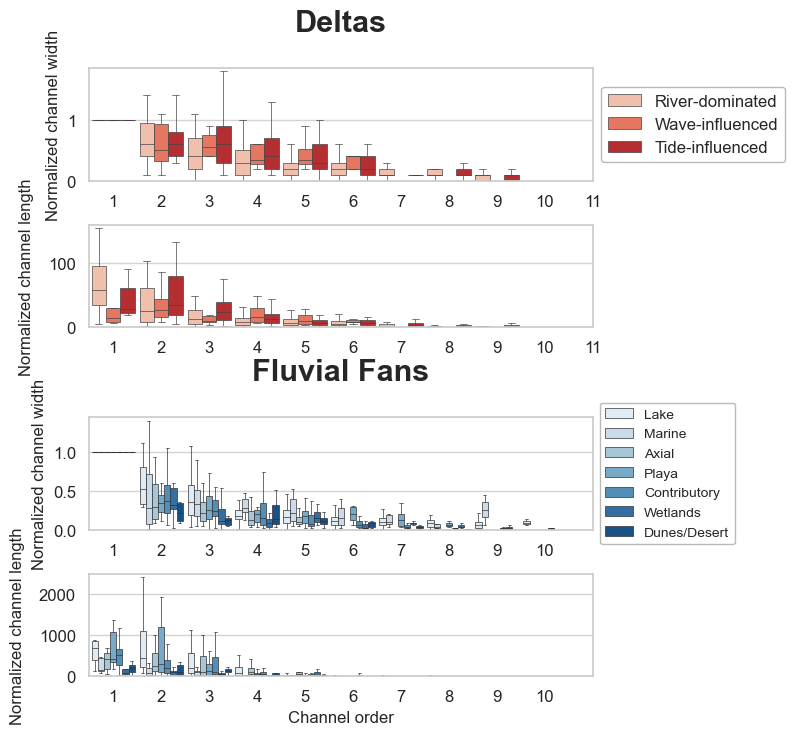

In [46]:
# Set white background with light grey grid lines
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "lightgrey"})

# Create subplots with grid layout
fig = plt.figure(figsize=(6.5, 8.5))  # Extra space for subheadings
gs = gridspec.GridSpec(6, 1, height_ratios=[0.05, 2.2, 2, 0.05, 2.2, 2])  # Include space for subheadings

# Subheading for Deltas
ax_subtitle1 = plt.subplot(gs[0])
ax_subtitle1.text(0.5, 0.5, "Deltas", ha="center", va="center", fontsize=22, fontweight='bold')
ax_subtitle1.axis("off")

# Plot a
ax0 = plt.subplot(gs[1])
sns.boxplot(
    y=LWData.NormChannelWidth,
    x=LWData.ChannelOrder,
    data=LWData,
    palette="Reds",
    hue='Type',
    width=.9,
    linewidth=.5,
    fliersize=0,
    ax=ax0
)
ax0.set_xlabel('')
ax0.set_ylabel('Normalized channel width', fontsize=12)
ax0.tick_params(axis='both', labelsize=12)
ax0.set_ylim(0, 1.85)
ax0.set_xlim(-0.5, 10)
ax0.set_xticklabels([str(int(float(label.get_text()))) for label in ax0.get_xticklabels()])

legend0 = ax0.legend(fontsize=12, bbox_to_anchor=(1, 0.5), loc='center left')
legend0.get_frame().set_facecolor('white')
legend0.get_frame().set_edgecolor('darkgrey')
for artist in ax0.artists:
    artist.set_edgecolor('black')

# Plot b
ax1 = plt.subplot(gs[2])
sns.boxplot(
    y=LWData.NormChannelLength,
    x=LWData.ChannelOrder,
    data=LWData,
    palette="Reds",
    hue='Type',
    width=.9,
    linewidth=.5,
    fliersize=0,
    ax=ax1
)
ax1.set_xlabel('')
ax1.set_ylabel('Normalized channel length', fontsize=12, labelpad=10)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlim(-0.5, 10)
ax1.set_ylim(0, 160)
ax1.set_xticklabels([str(int(float(label.get_text()))) for label in ax1.get_xticklabels()])
ax1.legend().set_visible(False)
for artist in ax1.artists:
    artist.set_edgecolor('black')

# Subheading for Fluvial Fans
ax_subtitle2 = plt.subplot(gs[3])
ax_subtitle2.text(0.5, 0.4, "Fluvial Fans", ha="center", va="center", fontsize=22, fontweight='bold')
ax_subtitle2.axis("off")

# Plot c
ax2 = plt.subplot(gs[4])
sns.boxplot(
    y=LWDataFan.NormChannelWidth,
    x=LWDataFan.ChannelOrder,
    data=LWDataFan,
    width=.9,
    linewidth=.5,
    palette="Blues",
    hue='Type',
    fliersize=0,
    ax=ax2
)
ax2.set_xlabel('')
ax2.set_ylabel('Normalized channel width', fontsize=12)
ax2.set_xlim(-0.5, 10)
ax2.set_ylim(0, 1.45)
ax2.tick_params(axis='both', labelsize=12)

legend2 = ax2.legend(fontsize=10, bbox_to_anchor=(1, 0.5), loc='center left')
legend2.get_frame().set_facecolor('white')
legend2.get_frame().set_edgecolor('darkgrey')
for artist in ax2.artists:
    artist.set_edgecolor('black')

# Plot d
ax3 = plt.subplot(gs[5])
sns.boxplot(
    y=LWDataFan.NormChannelLength,
    x=LWDataFan.ChannelOrder,
    data=LWDataFan,
    width=.9,
    linewidth=.5,
    palette="Blues",
    hue='Type',
    fliersize=0,
    ax=ax3
)
ax3.set_xlabel('Channel order', fontsize=12)
ax3.set_ylabel('Normalized channel length', fontsize=12, labelpad=10)
ax3.set_xlim(-0.5, 10)
ax3.set_ylim(0, 2500)
ax3.set_yscale('linear')
ax3.tick_params(axis='both', labelsize=12)
ax3.legend().set_visible(False)
for artist in ax3.artists:
    artist.set_edgecolor('black')

# Adjust layout spacing
plt.subplots_adjust(hspace=0.6)

# Show plot
plt.show()

C:\Users\lukej\AppData\Local\Temp\ipykernel_29096\3982138901.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_avg['color'].fillna('gray', inplace=True)


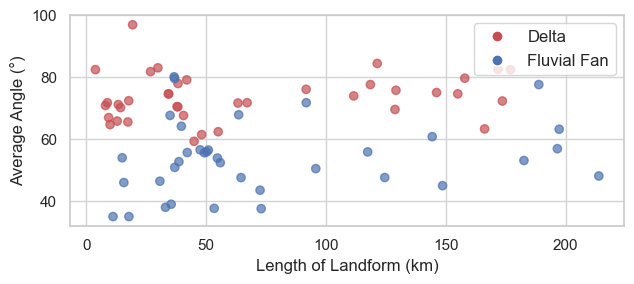

In [47]:
# Load landform metadata and angle data
df = pd.read_csv('Landforms.csv')
delta_angles = pd.read_csv('DeltaAngles.csv')
fan_angles = pd.read_csv('FluvialFanAngles.csv')

# Compute average angle per landform
delta_avg_angle = delta_angles.groupby('Name')['Angle'].mean().reset_index()
fan_avg_angle = fan_angles.groupby('Name')['Angle'].mean().reset_index()

# Merge with landform metadata
merged_avg = pd.merge(df, delta_avg_angle, how='left', on='Name')
merged_avg = pd.merge(merged_avg, fan_avg_angle, how='left', on='Name', suffixes=('_Delta', '_Fan'))

# Prioritize Delta angle, fallback to Fan if Delta is NaN
merged_avg['AvgAngle'] = merged_avg['Angle_Delta'].combine_first(merged_avg['Angle_Fan'])

# Assign colors by Type
merged_avg['color'] = merged_avg['Type'].map({'Delta': 'r', 'Fluvial Fan': 'b'})
merged_avg['color'].fillna('gray', inplace=True)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Delta', markerfacecolor='r', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Fluvial Fan', markerfacecolor='b', markersize=8)
]

# Plot
plt.figure(figsize=(6.5, 3))
plt.scatter(merged_avg['Length'], merged_avg['AvgAngle'], c=merged_avg['color'], alpha=0.7)

plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.xlabel('Length of Landform (km)')
plt.ylabel('Average Angle (°)')
plt.grid(True)
plt.tight_layout()
plt.show()


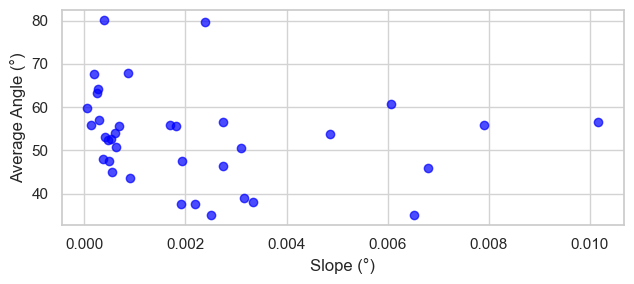

In [48]:
# Load your data
df = pd.read_csv('landforms.csv')  # Must have 'Name' and 'Slope'
# ADataFan should already be loaded with 'Name' and 'Angle'

# Step 1: Average angle for each fan
avg_angles = ADataFan.groupby('Name')['Angle'].mean().reset_index()
avg_angles.rename(columns={'Angle': 'Avg_Angle'}, inplace=True)

# Step 2: Merge with slopes
merged_df = pd.merge(avg_angles, df[['Name', 'Slope']], on='Name', how='inner')

# Step 3: Create scatter plot (styled to match, with flipped axes)
plt.figure(figsize=(6.5, 3))
plt.scatter(merged_df['Slope'], merged_df['Avg_Angle'], color='blue', alpha=0.7)

# Labels and formatting (flipped)
plt.xlabel('Slope (°)', fontsize=12)
plt.ylabel('Average Angle (°)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
